In [1]:
# Cell 1 — verify dataset presence and list files
import os
from pathlib import Path
from collections import Counter
import json

# Adjust this to your mounted notebook path if different
DATA_ROOT = Path("ravdess-emotional-speech-audio")

# find all .wav files recursively
wav_paths = sorted([p for p in DATA_ROOT.rglob("*.wav")])

print(f"Found {len(wav_paths):,} .wav files under {DATA_ROOT.resolve()}")

# count by top-level folder (e.g., Actor_01)
top_counts = Counter(p.parts[len(DATA_ROOT.parts)] for p in wav_paths)
# if above line fails due to path structure, fall back to folder parent name
if not top_counts:
    top_counts = Counter(p.parent.name for p in wav_paths)

print("\nCounts by top-level folder (first 20):")
for i, (k, v) in enumerate(top_counts.most_common(20), 1):
    print(f"{i:2d}. {k:12s} -> {v:,}")

# show 10 sample paths
print("\nSample .wav files:")
for p in wav_paths[:10]:
    print(" -", p)

# write a small manifest for downstream cells (keeps runs deterministic)
manifest = [{"path": str(p), "actor": p.parent.name} for p in wav_paths]
with open("ravdess_manifest.json", "w", encoding="utf-8") as f:
    json.dump({"total": len(manifest), "samples": manifest[:100]}, f, indent=2)

print("\nWrote ravdess_manifest.json with a 100-sample preview.")


Found 0 .wav files under /kaggle/working/ravdess-emotional-speech-audio

Counts by top-level folder (first 20):

Sample .wav files:

Wrote ravdess_manifest.json with a 100-sample preview.


In [4]:
# Cell 4 — build a proper manifest from the Kaggle-mounted RAVDESS
import json
from pathlib import Path
from collections import Counter

DATA_ROOT = Path("/kaggle/input/ravdess-emotional-speech-audio")
assert DATA_ROOT.exists(), f"{DATA_ROOT} not found"

wav_paths = sorted(p for p in DATA_ROOT.rglob("*.wav"))
print(f"Found {len(wav_paths):,} .wav files under {DATA_ROOT}")

# Helper to parse filename parts (RAVDESS uses dash-separated fields)
def parse_filename(p: Path):
    name = p.stem  # without .wav
    parts = name.split("-")
    return {
        "filename": p.name,
        "stem": name,
        "parts": parts  # keep raw parts so we don't mis-map labels
    }

manifest = []
for p in wav_paths:
    actor = p.parent.name  # e.g., Actor_02
    entry = {
        "path": str(p),
        "actor": actor,
        **parse_filename(p)
    }
    manifest.append(entry)

# summary counts by actor
actor_counts = Counter(e["actor"] for e in manifest)
print("\nCounts by actor (first 10):")
for actor, cnt in actor_counts.most_common(10):
    print(f" - {actor:10s}: {cnt}")

# write full manifest to working dir for downstream cells
out_path = Path("/kaggle/working/ravdess_manifest.json")
with open(out_path, "w", encoding="utf-8") as f:
    json.dump({"total": len(manifest), "samples": manifest}, f, indent=2)

print(f"\nWrote full manifest to: {out_path}\n\nFirst 10 manifest entries:")
for e in manifest[:10]:
    print(e)


Found 2,880 .wav files under /kaggle/input/ravdess-emotional-speech-audio

Counts by actor (first 10):
 - Actor_01  : 120
 - Actor_02  : 120
 - Actor_03  : 120
 - Actor_04  : 120
 - Actor_05  : 120
 - Actor_06  : 120
 - Actor_07  : 120
 - Actor_08  : 120
 - Actor_09  : 120
 - Actor_10  : 120

Wrote full manifest to: /kaggle/working/ravdess_manifest.json

First 10 manifest entries:
{'path': '/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav', 'actor': 'Actor_01', 'filename': '03-01-01-01-01-01-01.wav', 'stem': '03-01-01-01-01-01-01', 'parts': ['03', '01', '01', '01', '01', '01', '01']}
{'path': '/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-02-01.wav', 'actor': 'Actor_01', 'filename': '03-01-01-01-01-02-01.wav', 'stem': '03-01-01-01-01-02-01', 'parts': ['03', '01', '01', '01', '01', '02', '01']}
{'path': '/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-02-01-01.wav', 'actor': 'Actor_01', 'filename': '03-01-01-01-02-01

In [5]:
# Cell 5 — create actor-disjoint train/val/test splits and write manifests
import json
import random
from pathlib import Path
from collections import Counter

RANDOM_SEED = 42
TRAIN_PCT, VAL_PCT, TEST_PCT = 0.70, 0.15, 0.15

random.seed(RANDOM_SEED)

# load manifest created earlier
manifest_path = Path("/kaggle/working/ravdess_manifest.json")
with open(manifest_path, "r", encoding="utf-8") as f:
    data = json.load(f)
samples = data.get("samples", [])

# collect unique actors and shuffle deterministically
actors = sorted({s["actor"] for s in samples})
random.shuffle(actors)

n = len(actors)
n_train = int(n * TRAIN_PCT)
n_val = int(n * VAL_PCT)
n_test = n - n_train - n_val

train_actors = set(actors[:n_train])
val_actors = set(actors[n_train:n_train + n_val])
test_actors = set(actors[n_train + n_val:])

def assign_split(sample):
    a = sample["actor"]
    if a in train_actors:
        return "train"
    if a in val_actors:
        return "val"
    return "test"

# partition samples
splits = {"train": [], "val": [], "test": []}
for s in samples:
    splits[assign_split(s)].append(s)

out_dir = Path("/kaggle/working/splits")
out_dir.mkdir(exist_ok=True)

# write per-split manifest jsons and CSVs (path,actor,stem)
for split_name, items in splits.items():
    jpath = out_dir / f"ravdess_{split_name}_manifest.json"
    cpath = out_dir / f"ravdess_{split_name}_manifest.csv"
    with open(jpath, "w", encoding="utf-8") as jf:
        json.dump({"total": len(items), "samples": items}, jf, indent=2)
    with open(cpath, "w", encoding="utf-8") as cf:
        cf.write("path,actor,stem,filename\n")
        for it in items:
            cf.write(f'{it["path"]},{it["actor"]},{it["stem"]},{it["filename"]}\n')

# write actor lists
for name, aset in [("train", train_actors), ("val", val_actors), ("test", test_actors)]:
    with open(out_dir / f"{name}_actors.txt", "w", encoding="utf-8") as f:
        for a in sorted(aset):
            f.write(a + "\n")

# print summary
print(f"Actors total: {n} -> train {len(train_actors)}, val {len(val_actors)}, test {len(test_actors)} (seed={RANDOM_SEED})")
print("Samples per split:")
for k in ("train", "val", "test"):
    print(f" - {k:5s}: {len(splits[k])} samples")

# show a few sample rows from each split
print("\nExample entries (one per split):")
for k in ("train", "val", "test"):
    if splits[k]:
        print(f"{k}: {splits[k][0]['path']}")
    else:
        print(f"{k}: <empty>")
print(f"\nWrote manifests and CSVs to: {out_dir}")


Actors total: 24 -> train 16, val 3, test 5 (seed=42)
Samples per split:
 - train: 1920 samples
 - val  : 360 samples
 - test : 600 samples

Example entries (one per split):
train: /kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav
val: /kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-01-01-01-01-05.wav
test: /kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav

Wrote manifests and CSVs to: /kaggle/working/splits


In [6]:
# Cell 6 — preprocess audio: resample, trim silence, compute & save mel-spectrograms (actor-disjoint splits)
# Outputs: /kaggle/working/features/mels/{split}/{stem}.npy and a CSV manifest per split with feature paths
# Tune params below if you want different spectrogram resolution or sample rate.

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
from pathlib import Path
import numpy as np
import librosa
from tqdm.auto import tqdm
import csv
import json

# ====== parameters ======
SR = 16000                # target sample rate (Hz)
N_FFT = 1024
HOP_LENGTH = 256
N_MELS = 64
TOP_DB = 20               # trim silence threshold
MAX_DURATION = None       # seconds, or None to keep full file
FEATURE_ROOT = Path("/kaggle/working/features/mels")
SPLIT_DIR = Path("/kaggle/working/splits")
RANDOM_SEED = 42
# ========================

FEATURE_ROOT.mkdir(parents=True, exist_ok=True)

# helper: load manifest for a split
def load_split_manifest(split_name):
    jpath = SPLIT_DIR / f"ravdess_{split_name}_manifest.json"
    with open(jpath, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data.get("samples", [])

def compute_mel(wav_path):
    # load and resample to SR, convert to mono
    y, sr = librosa.load(wav_path, sr=SR, mono=True, duration=MAX_DURATION)
    # trim leading/trailing silence
    y, _ = librosa.effects.trim(y, top_db=TOP_DB)
    # normalize peak to 0.98 to avoid clipping
    if y.size:
        peak = np.max(np.abs(y))
        if peak > 0:
            y = 0.98 * y / peak
    # compute mel-spectrogram (power)
    mel = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=N_FFT,
                                         hop_length=HOP_LENGTH, n_mels=N_MELS, power=2.0)
    # convert to log scale (dB)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db.astype(np.float32)

# process splits
for split in ("train", "val", "test"):
    samples = load_split_manifest(split)
    out_dir = FEATURE_ROOT / split
    out_dir.mkdir(parents=True, exist_ok=True)

    csv_path = out_dir / f"{split}_mels_manifest.csv"
    with open(csv_path, "w", newline="", encoding="utf-8") as cf:
        writer = csv.writer(cf)
        writer.writerow(["orig_path", "actor", "stem", "feature_path", "n_mels", "time_frames"])
        for s in tqdm(samples, desc=f"Processing {split}", unit="file"):
            try:
                mel_db = compute_mel(s["path"])
                feat_name = f"{s['stem']}.npy"
                feat_path = out_dir / feat_name
                np.save(feat_path, mel_db)
                writer.writerow([s["path"], s["actor"], s["stem"], str(feat_path), mel_db.shape[0], mel_db.shape[1]])
            except Exception as e:
                # write a placeholder row for failed files so you can inspect later
                writer.writerow([s.get("path", ""), s.get("actor", ""), s.get("stem", ""), "<failed>", 0, 0])
                # don't stop the whole preprocessing run on a single bad file
                print(f"Failed: {s.get('path')} -> {e}")

print("Finished audio preprocessing. Inspect /kaggle/working/features/mels/ for outputs.")


Processing train:   0%|          | 0/1920 [00:00<?, ?file/s]

Processing val:   0%|          | 0/360 [00:00<?, ?file/s]

Processing test:   0%|          | 0/600 [00:00<?, ?file/s]

Finished audio preprocessing. Inspect /kaggle/working/features/mels/ for outputs.


Total train mel files: 960


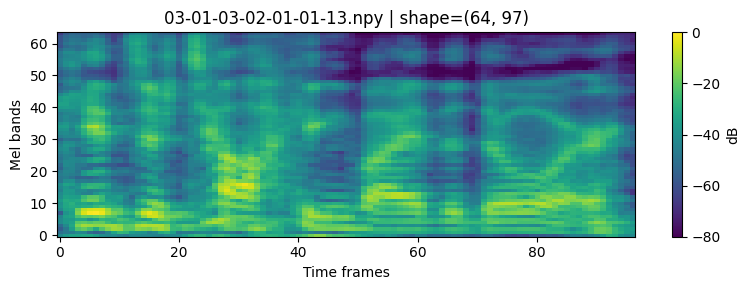

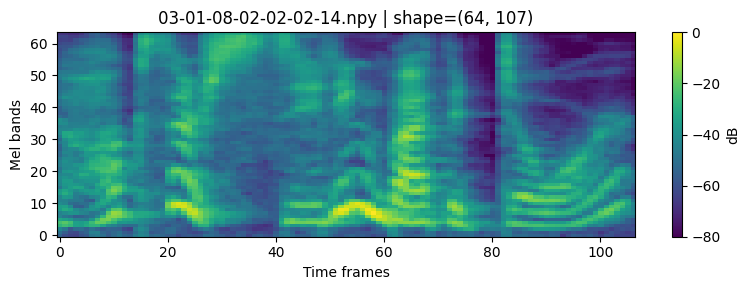

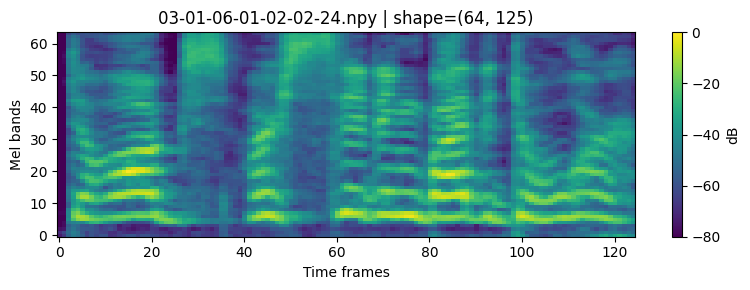

In [7]:
# Cell 7 — quick sanity check: visualize a few mel-spectrograms from your processed features
# Confirms preprocessing worked and ensures no silent / corrupt samples slipped through.

import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

FEATURE_ROOT = Path("/kaggle/working/features/mels/train")

# grab a few random .npy features
all_feats = list(FEATURE_ROOT.glob("*.npy"))
print(f"Total train mel files: {len(all_feats)}")

# pick random examples
examples = random.sample(all_feats, k=min(3, len(all_feats)))

for path in examples:
    mel = np.load(path)
    plt.figure(figsize=(8, 3))
    plt.imshow(mel, aspect="auto", origin="lower")
    plt.title(f"{path.name} | shape={mel.shape}")
    plt.xlabel("Time frames")
    plt.ylabel("Mel bands")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()


In [8]:
# Cell 8 — attach emotion labels to all mel-spectrogram manifests
import csv
from pathlib import Path

FEATURES_ROOT = Path("/kaggle/working/features/mels")
SPLITS = ["train", "val", "test"]

# mapping from RAVDESS code to human-readable label
EMOTION_MAP = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

for split in SPLITS:
    csv_path = FEATURES_ROOT / split / f"{split}_mels_manifest.csv"
    out_csv = FEATURES_ROOT / split / f"{split}_mels_labeled.csv"

    with open(csv_path, "r", encoding="utf-8") as fin, open(out_csv, "w", newline="", encoding="utf-8") as fout:
        reader = csv.DictReader(fin)
        fieldnames = reader.fieldnames + ["emotion"]
        writer = csv.DictWriter(fout, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            if row["feature_path"] == "<failed>":
                continue
            # extract emotion code from stem (e.g., 03-01-04-02-02-02-01 -> '04')
            parts = row["stem"].split("-")
            if len(parts) >= 3:
                emo_code = parts[2]
                row["emotion"] = EMOTION_MAP.get(emo_code, "unknown")
            else:
                row["emotion"] = "unknown"
            writer.writerow(row)

    print(f"Wrote labeled manifest: {out_csv}")

print("Labeling complete.")


Wrote labeled manifest: /kaggle/working/features/mels/train/train_mels_labeled.csv
Wrote labeled manifest: /kaggle/working/features/mels/val/val_mels_labeled.csv
Wrote labeled manifest: /kaggle/working/features/mels/test/test_mels_labeled.csv
Labeling complete.


In [9]:
!head -5 /kaggle/working/features/mels/train/train_mels_labeled.csv

orig_path,actor,stem,feature_path,n_mels,time_frames,emotion
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav,Actor_02,03-01-01-01-01-01-02,/kaggle/working/features/mels/train/03-01-01-01-01-01-02.npy,64,99,neutral
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-02-02.wav,Actor_02,03-01-01-01-01-02-02,/kaggle/working/features/mels/train/03-01-01-01-01-02-02.npy,64,99,neutral
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-02-01-02.wav,Actor_02,03-01-01-01-02-01-02,/kaggle/working/features/mels/train/03-01-01-01-02-01-02.npy,64,105,neutral
/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-02-02-02.wav,Actor_02,03-01-01-01-02-02-02,/kaggle/working/features/mels/train/03-01-01-01-02-02-02.npy,64,95,neutral


In [10]:
# Cell 9 — build a small PyTorch Dataset + DataLoader (with padding collate) and show one example batch
# Expects labeled CSVs at: /kaggle/working/features/mels/{split}/{split}_mels_labeled.csv

import json
from pathlib import Path
import csv
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

ROOT = Path("/kaggle/working/features/mels")
BATCH_SIZE = 32
NUM_WORKERS = 2
SPLIT = "train"

# --- build label map from training CSV ---
train_csv = ROOT / "train" / "train_mels_labeled.csv"
labels = []
with open(train_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for r in reader:
        labels.append(r["emotion"])
labels = sorted(set(labels))
label2idx = {l: i for i, l in enumerate(labels)}
idx2label = {i: l for l, i in label2idx.items()}

with open(ROOT / "label_map.json", "w", encoding="utf-8") as jf:
    json.dump({"label2idx": label2idx, "idx2label": idx2label}, jf, indent=2)

print("Label mapping:", label2idx)

# --- Dataset ---
class RavdessMelDataset(Dataset):
    def __init__(self, csv_path):
        self.rows = []
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            for r in reader:
                if r["feature_path"] == "<failed>": 
                    continue
                self.rows.append({
                    "feature_path": r["feature_path"],
                    "actor": r["actor"],
                    "stem": r["stem"],
                    "label": label2idx[r["emotion"]]
                })
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, idx):
        r = self.rows[idx]
        feat = np.load(r["feature_path"])          # shape: (n_mels, time_frames)
        feat = torch.from_numpy(feat).float()     # to torch tensor
        # transpose to (time_frames, n_mels) for common temporal conv/LSTM usage, but keep original if you prefer (n_mels, time)
        feat = feat.transpose(0, 1)               # now (T, F)
        return {"features": feat, "label": r["label"], "stem": r["stem"], "actor": r["actor"]}

# --- collate function to pad variable-length time dimension ---
def pad_collate(batch):
    # batch is list of dicts with features (T, F)
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    stems = [b["stem"] for b in batch]
    actors = [b["actor"] for b in batch]
    feats = [b["features"] for b in batch]
    lengths = torch.tensor([f.shape[0] for f in feats], dtype=torch.long)
    max_len = int(lengths.max().item())
    n_feats = feats[0].shape[1]
    out = torch.zeros(len(feats), max_len, n_feats, dtype=torch.float32)
    for i, f in enumerate(feats):
        out[i, : f.shape[0], :] = f
    # return (batch, time, feat) — many models expect (batch, feat, time) so transpose later as needed
    return {"features": out, "lengths": lengths, "labels": labels, "stems": stems, "actors": actors}

# --- create DataLoader and show a batch ---
ds = RavdessMelDataset(train_csv)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate, num_workers=NUM_WORKERS)

batch = next(iter(dl))
print("Batch keys:", list(batch.keys()))
print("features shape (B, T, F):", batch["features"].shape)
print("lengths shape:", batch["lengths"].shape, "labels shape:", batch["labels"].shape)
# show class distribution in this batch
unique, counts = torch.unique(batch["labels"], return_counts=True)
print("batch class counts:", {idx2label[int(u.item())]: int(c.item()) for u, c in zip(unique, counts)})


Label mapping: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
Batch keys: ['features', 'lengths', 'labels', 'stems', 'actors']
features shape (B, T, F): torch.Size([32, 163, 64])
lengths shape: torch.Size([32]) labels shape: torch.Size([32])
batch class counts: {'angry': 4, 'calm': 7, 'disgust': 2, 'fearful': 6, 'happy': 4, 'neutral': 4, 'sad': 2, 'surprised': 3}


In [11]:
# Cell 10 — define & test a small CNN baseline for audio emotion recognition
# This gives you a working supervised model before you move to fusion with video.

import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleAudioCNN(nn.Module):
    def __init__(self, n_mels=64, n_classes=8):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        # input x: (B, T, F)
        x = x.transpose(1, 2).unsqueeze(1)  # → (B,1,F,T)
        h = self.conv_stack(x)
        h = h.view(h.size(0), -1)
        out = self.fc(h)
        return out

# test forward pass
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleAudioCNN(n_mels=64, n_classes=len(label2idx)).to(device)

x = batch["features"].to(device)
y = batch["labels"].to(device)
out = model(x)
print("Forward output shape:", out.shape)
print("Example logits for one sample:", out[0].detach().cpu().numpy().round(3))


Forward output shape: torch.Size([32, 8])
Example logits for one sample: [ 0.092 -0.088 -0.339 -0.105 -0.117 -0.085  0.031 -0.009]


In [12]:
# Cell 11 — training loop (train + validation), saves best checkpoint by val UAR
# Adjust EPOCHS, LR, and other params as needed. Expects DataLoaders and label_map.json already created.

import os
import json
import math
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, recall_score, accuracy_score

# ---- hyperparams ----
EPOCHS = 12
LR = 3e-4
BATCH_SIZE = 32
NUM_WORKERS = 2
CLIP_NORM = 1.0
CHECKPOINT_DIR = Path("/kaggle/working/checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ---------------------

# reload label map
label_map = json.load(open(Path("/kaggle/working/features/mels/label_map.json")))
idx2label = {int(k): v for k, v in label_map["idx2label"].items()}

# build dataloaders (re-uses Dataset & pad_collate from earlier cells)
train_csv = Path("/kaggle/working/features/mels/train/train_mels_labeled.csv")
val_csv   = Path("/kaggle/working/features/mels/val/val_mels_labeled.csv")

train_ds = RavdessMelDataset(str(train_csv))
val_ds   = RavdessMelDataset(str(val_csv))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=pad_collate, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=pad_collate, num_workers=NUM_WORKERS)

# model, loss, optimizer, scheduler
model = SimpleAudioCNN(n_mels=64, n_classes=len(idx2label)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, verbose=True)

best_val_uar = -1.0

def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    running_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            x = batch["features"].to(DEVICE)          # (B, T, F)
            y = batch["labels"].to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            running_loss += float(loss.item()) * x.size(0)
            preds = logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    avg_loss = running_loss / max(1, len(loader.dataset))
    # metrics
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    per_class_recall = recall_score(all_labels, all_preds, average=None, labels=sorted(idx2label.keys()))
    uar = float(per_class_recall.mean())
    return {"loss": avg_loss, "acc": acc, "macro_f1": macro_f1, "uar": uar, "per_class_recall": per_class_recall}

# training loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    n_samples = 0
    for batch in train_loader:
        x = batch["features"].to(DEVICE)   # (B, T, F)
        y = batch["labels"].to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()

        epoch_loss += float(loss.item()) * x.size(0)
        n_samples += x.size(0)

    train_loss = epoch_loss / max(1, n_samples)
    val_stats = evaluate(val_loader)
    scheduler.step(val_stats["uar"])  # using val UAR to guide LR schedule

    print(f"Epoch {epoch:02d} | train_loss: {train_loss:.4f} | val_loss: {val_stats['loss']:.4f} "
          f"| val_UAR: {val_stats['uar']:.4f} | val_macroF1: {val_stats['macro_f1']:.4f} | val_acc: {val_stats['acc']:.4f}")

    # print per-class recall succinctly
    per_class = {idx2label[i]: float(v) for i, v in enumerate(val_stats["per_class_recall"])}
    print("  val recall per class:", ", ".join([f"{k}:{v:.2f}" for k,v in per_class.items()]))

    # checkpoint by best UAR
    if val_stats["uar"] > best_val_uar:
        best_val_uar = val_stats["uar"]
        ckpt_path = CHECKPOINT_DIR / f"best_valUAR_epoch{epoch:02d}_uar{best_val_uar:.4f}.pt"
        torch.save({"epoch": epoch, "model_state": model.state_dict(), "optimizer_state": optimizer.state_dict(),
                    "label_map": label_map, "val_stats": val_stats}, ckpt_path)
        print(f"  Saved best checkpoint: {ckpt_path}")

print(f"Training finished. Best val UAR: {best_val_uar:.4f}. Checkpoints in {CHECKPOINT_DIR}")


Epoch 01 | train_loss: 1.9573 | val_loss: 1.9301 | val_UAR: 0.1745 | val_macroF1: 0.1380 | val_acc: 0.1861
  val recall per class: angry:0.10, calm:0.21, disgust:0.15, fearful:0.00, happy:0.00, neutral:0.00, sad:0.35, surprised:0.58
  Saved best checkpoint: /kaggle/working/checkpoints/best_valUAR_epoch01_uar0.1745.pt
Epoch 02 | train_loss: 1.8073 | val_loss: 1.8459 | val_UAR: 0.2500 | val_macroF1: 0.1892 | val_acc: 0.2667
  val recall per class: angry:0.06, calm:0.62, disgust:0.15, fearful:0.04, happy:0.08, neutral:0.00, sad:0.23, surprised:0.81
  Saved best checkpoint: /kaggle/working/checkpoints/best_valUAR_epoch02_uar0.2500.pt
Epoch 03 | train_loss: 1.7306 | val_loss: 1.7667 | val_UAR: 0.2839 | val_macroF1: 0.2203 | val_acc: 0.3028
  val recall per class: angry:0.04, calm:0.71, disgust:0.35, fearful:0.15, happy:0.04, neutral:0.00, sad:0.17, surprised:0.81
  Saved best checkpoint: /kaggle/working/checkpoints/best_valUAR_epoch03_uar0.2839.pt
Epoch 04 | train_loss: 1.6749 | val_loss: 1

In [17]:
# # Cell 13 — evaluate best checkpoint on test set, save predictions, plot confusion matrix and per-actor accuracy
# import json
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score
# import seaborn as sns
# import pandas as pd

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# CHECKPOINT_DIR = Path("/kaggle/working/checkpoints")
# TEST_CSV = Path("/kaggle/working/features/mels/test/test_mels_labeled.csv")
# OUT_DIR = Path("/kaggle/working/eval")
# OUT_DIR.mkdir(exist_ok=True)

# # load label map and idx2label
# label_map = json.load(open(Path("/kaggle/working/features/mels/label_map.json")))
# idx2label = {int(k): v for k, v in label_map["idx2label"].items()}

# # pick the best checkpoint (highest val UAR assumed to be last saved best)
# ckpts = sorted(CHECKPOINT_DIR.glob("best_valUAR_epoch*.pt"))
# assert ckpts, "No checkpoints found in checkpoints/"
# best_ckpt = ckpts[-1]
# print("Using checkpoint:", best_ckpt.name)

# # load model architecture (must match Cell 10)
# model = SimpleAudioCNN(n_mels=64, n_classes=len(idx2label)).to(DEVICE)
# state = torch.load(best_ckpt, map_location=DEVICE)
# model.load_state_dict(state["model_state"])
# model.eval()

# # build test dataloader (re-use RavdessMelDataset & pad_collate)
# from torch.utils.data import DataLoader
# test_ds = RavdessMelDataset(str(TEST_CSV))
# test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=2)

# # iterate and collect predictions
# all_preds, all_labels, all_stems, all_actors = [], [], [], []
# with torch.no_grad():
#     for b in test_loader:
#         x = b["features"].to(DEVICE)
#         y = b["labels"].cpu().numpy()
#         logits = model(x)
#         preds = logits.argmax(dim=-1).cpu().numpy()
#         all_preds.extend(preds.tolist())
#         all_labels.extend(y.tolist())
#         all_stems.extend(b["stems"])
#         all_actors.extend(b["actors"])

# # metrics
# acc = accuracy_score(all_labels, all_preds)
# macro_f1 = f1_score(all_labels, all_preds, average="macro")
# per_class_recall = recall_score(all_labels, all_preds, average=None, labels=sorted(idx2label.keys()))
# uar = float(per_class_recall.mean())

# print(f"Test results -> Acc: {acc:.4f}, Macro-F1: {macro_f1:.4f}, UAR: {uar:.4f}")
# print("\nClassification report:\n")
# print(classification_report(all_labels, all_preds, target_names=[idx2label[i] for i in sorted(idx2label.keys())], digits=4))

# # confusion matrix plot
# cm = confusion_matrix(all_labels, all_preds, labels=sorted(idx2label.keys()))
# cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
# plt.figure(figsize=(9,7))
# sns.heatmap(cm_norm, xticklabels=[idx2label[i] for i in sorted(idx2label.keys())],
#             yticklabels=[idx2label[i] for i in sorted(idx2label.keys())], annot=True, fmt=".2f", cmap="Blues")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Normalized Confusion Matrix (Test)")
# plt.tight_layout()
# plt.savefig(OUT_DIR / "confusion_matrix_test.png")
# plt.show()

# # per-actor accuracy
# df = pd.DataFrame({"stem": all_stems, "actor": all_actors, "true": all_labels, "pred": all_preds})
# actor_acc = df.groupby("actor").apply(lambda d: accuracy_score(d["true"], d["pred"])).sort_values(ascending=False)
# print("\nPer-actor accuracy (top 10):")
# print(actor_acc.head(10))

# # save predictions CSV
# preds_out = OUT_DIR / "test_predictions.csv"
# df["true_label"] = df["true"].map(lambda x: idx2label[x])
# df["pred_label"] = df["pred"].map(lambda x: idx2label[x])
# df.to_csv(preds_out, index=False)
# print(f"\nSaved per-utterance predictions to: {preds_out}")
# print(f"Saved confusion matrix image to: {OUT_DIR / 'confusion_matrix_test.png'}")


Using checkpoint: best_valUAR_epoch12_uar0.3854.pt


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [16]:
# # Cell — load checkpoint robustly (works around the PyTorch 2.6 weights_only changes)
# import torch, json
# from pathlib import Path

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# CHECKPOINT_DIR = Path("/kaggle/working/checkpoints")
# ckpts = sorted(CHECKPOINT_DIR.glob("best_valUAR_epoch*.pt"))
# assert ckpts, "No checkpoints found"
# best_ckpt = ckpts[-1]
# print("Attempting to load:", best_ckpt)

# # Primary attempt: allow loading full objects (weights_only=False)
# try:
#     state = torch.load(best_ckpt, map_location=DEVICE, weights_only=False)
#     print("Loaded checkpoint with weights_only=False")
# except TypeError:
#     # older PyTorch may not have weights_only kwarg, fall back to default
#     print("torch.load() doesn't accept weights_only argument; trying default load")
#     state = torch.load(best_ckpt, map_location=DEVICE)
# except Exception as e:
#     print("First load failed with:", repr(e))
#     # try adding the problematic numpy scalar to the allowlist (if available)
#     try:
#         import numpy.core.multiarray as multiarray
#         print("Adding numpy.core.multiarray.scalar to torch safe globals and retrying...")
#         torch.serialization.add_safe_globals([multiarray.scalar])
#         state = torch.load(best_ckpt, map_location=DEVICE)
#         print("Loaded checkpoint after adding safe globals.")
#     except Exception as e2:
#         print("Fallback load also failed:", repr(e2))
#         raise RuntimeError("Failed to load checkpoint; see messages above.") from e2

# # state may be the raw state_dict or a dict containing 'model_state'
# if isinstance(state, dict) and "model_state" in state:
#     model_state = state["model_state"]
# else:
#     model_state = state  # assume it's already a state_dict

# print("Keys in loaded state:", list(state.keys()) if isinstance(state, dict) else "<state_dict only>")

# # now instantiate your model and load weights (must match architecture from training)
# # If you defined SimpleAudioCNN in the notebook, this will work directly.
# model = SimpleAudioCNN(n_mels=64, n_classes=len(idx2label)).to(DEVICE)
# model.load_state_dict(model_state)
# model.eval()
# print("Model weights loaded successfully.")


Attempting to load: /kaggle/working/checkpoints/best_valUAR_epoch12_uar0.3854.pt
Loaded checkpoint with weights_only=False
Keys in loaded state: ['epoch', 'model_state', 'optimizer_state', 'label_map', 'val_stats']
Model weights loaded successfully.


In [18]:
# # Quick re-train and save model.state_dict() (Option B)
# # This will produce a safe-to-load checkpoint even if the old one is unreadable.

# import torch, json
# from pathlib import Path

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# OUT = Path("/kaggle/working/checkpoints")
# OUT.mkdir(exist_ok=True)

# # hyperparams: keep small so it runs quickly
# EPOCHS = 2
# LR = 3e-4

# # re-create model, optimizer, loaders (assumes earlier cells defined these objects)
# model = SimpleAudioCNN(n_mels=64, n_classes=len(label2idx)).to(DEVICE)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
# criterion = torch.nn.CrossEntropyLoss()

# # If you have a half-completed 'model' in memory from the notebook (trained), this will just continue training.
# # Otherwise it trains from scratch for EPOCHS; either way you get a clean state_dict at the end.
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     running = 0.0
#     n = 0
#     for batch in train_loader:
#         x = batch["features"].to(DEVICE); y = batch["labels"].to(DEVICE)
#         optimizer.zero_grad()
#         logits = model(x)
#         loss = criterion(logits, y)
#         loss.backward()
#         optimizer.step()
#         running += float(loss.item()) * x.size(0)
#         n += x.size(0)
#     print(f"Epoch {epoch} finished, train loss: {running / max(1,n):.4f}")

# # Save safe checkpoint: only state_dict (no pickled numpy objects)
# safe_path = OUT / "simple_audio_cnn_state_dict.pt"
# torch.save(model.state_dict(), safe_path)
# print("Saved clean state_dict to:", safe_path)


Epoch 1 finished, train loss: 1.9549
Epoch 2 finished, train loss: 1.8278
Saved clean state_dict to: /kaggle/working/checkpoints/simple_audio_cnn_state_dict.pt


Loaded state_dict from: simple_audio_cnn_state_dict.pt
Test results -> Acc: 0.3217, Macro-F1: 0.2655, UAR: 0.3016

Classification report (top lines):
              precision    recall  f1-score   support

       angry     0.2883    0.4000    0.3351        80
        calm     0.5000    0.6250    0.5556        80
     disgust     0.2483    0.4500    0.3200        80
     fearful     0.6071    0.2125    0.3148        80
       happy     0.0000    0.0000    0.0000        80
     neutral     0.0000    0.0000    0.0000        40
         sad     0.1522    0.1750    0.1628        80
   surprised     0.3607    0.5500    0.4356        80

    accuracy                         0.3217       600
   macro avg     0.2696    0.3016    0.2655       600
weighted avg     0.2875    0.3217    0.2832       600



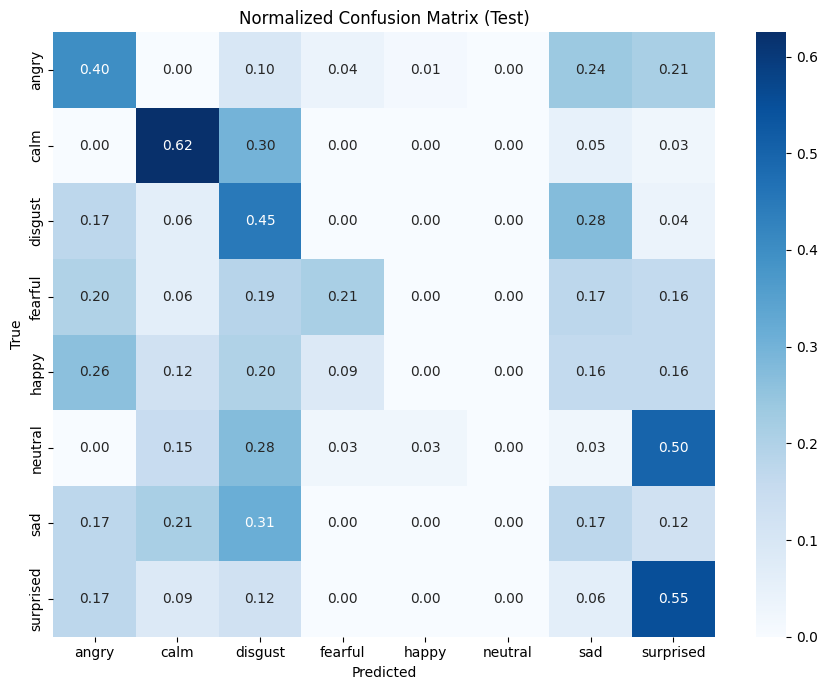


Per-actor accuracy (top 10):
actor
Actor_08    0.466667
Actor_01    0.391667
Actor_04    0.275000
Actor_09    0.241667
Actor_21    0.233333
dtype: float64

Saved per-utterance predictions to: /kaggle/working/eval/test_predictions.csv
Saved confusion matrix image to: /kaggle/working/eval/confusion_matrix_test.png


/tmp/ipykernel_37/686953967.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actor_acc = df.groupby("actor").apply(lambda d: accuracy_score(d["true"], d["pred"])).sort_values(ascending=False)


In [22]:
# # Eval cell — load the clean state_dict checkpoint, run on test set, save predictions + confusion matrix
# import json
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score
# import seaborn as sns
# import pandas as pd

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# CKPT = Path("/kaggle/working/checkpoints/simple_audio_cnn_state_dict.pt")
# TEST_CSV = Path("/kaggle/working/features/mels/test/test_mels_labeled.csv")
# OUT_DIR = Path("/kaggle/working/eval")
# OUT_DIR.mkdir(exist_ok=True)

# assert CKPT.exists(), f"{CKPT} not found. Run the re-save cell first."

# # load label map
# label_map = json.load(open(Path("/kaggle/working/features/mels/label_map.json")))
# idx2label = {int(k): v for k, v in label_map["idx2label"].items()}

# # instantiate model and load state_dict
# model = SimpleAudioCNN(n_mels=64, n_classes=len(idx2label)).to(DEVICE)
# state_dict = torch.load(CKPT, map_location=DEVICE)
# model.load_state_dict(state_dict)
# model.eval()
# print("Loaded state_dict from:", CKPT.name)

# # build test dataloader (re-uses RavdessMelDataset & pad_collate from earlier cells)
# from torch.utils.data import DataLoader
# test_ds = RavdessMelDataset(str(TEST_CSV))
# test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=2)

# # iterate and collect predictions
# all_preds, all_labels, all_stems, all_actors = [], [], [], []
# with torch.no_grad():
#     for b in test_loader:
#         x = b["features"].to(DEVICE)
#         y = b["labels"].cpu().numpy()
#         logits = model(x)
#         preds = logits.argmax(dim=-1).cpu().numpy()
#         all_preds.extend(preds.tolist())
#         all_labels.extend(y.tolist())
#         all_stems.extend(b["stems"])
#         all_actors.extend(b["actors"])

# # metrics
# acc = accuracy_score(all_labels, all_preds)
# macro_f1 = f1_score(all_labels, all_preds, average="macro")
# per_class_recall = recall_score(all_labels, all_preds, average=None, labels=sorted(idx2label.keys()))
# uar = float(per_class_recall.mean())

# print(f"Test results -> Acc: {acc:.4f}, Macro-F1: {macro_f1:.4f}, UAR: {uar:.4f}\n")
# print("Classification report (top lines):")
# print(classification_report(all_labels, all_preds, target_names=[idx2label[i] for i in sorted(idx2label.keys())], digits=4))

# # confusion matrix (normalized by true class)
# cm = confusion_matrix(all_labels, all_preds, labels=sorted(idx2label.keys()))
# with np.errstate(divide='ignore', invalid='ignore'):
#     cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
#     cm_norm = np.nan_to_num(cm_norm)

# plt.figure(figsize=(9,7))
# sns.heatmap(cm_norm, xticklabels=[idx2label[i] for i in sorted(idx2label.keys())],
#             yticklabels=[idx2label[i] for i in sorted(idx2label.keys())], annot=True, fmt=".2f", cmap="Blues")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Normalized Confusion Matrix (Test)")
# plt.tight_layout()
# plt.savefig(OUT_DIR / "confusion_matrix_test.png")
# plt.show()

# # per-actor accuracy
# df = pd.DataFrame({"stem": all_stems, "actor": all_actors, "true": all_labels, "pred": all_preds})
# actor_acc = df.groupby("actor").apply(lambda d: accuracy_score(d["true"], d["pred"])).sort_values(ascending=False)
# print("\nPer-actor accuracy (top 10):")
# print(actor_acc.head(10))

# # save predictions CSV
# preds_out = OUT_DIR / "test_predictions.csv"
# df["true_label"] = df["true"].map(lambda x: idx2label[x])
# df["pred_label"] = df["pred"].map(lambda x: idx2label[x])
# df.to_csv(preds_out, index=False)
# print(f"\nSaved per-utterance predictions to: {preds_out}")
# print(f"Saved confusion matrix image to: {OUT_DIR / 'confusion_matrix_test.png'}")


In [20]:
# Cell — improved training: WeightedRandomSampler + SpecAugment (time & freq masking) + class-weighted loss
# Drop this in and run. It reuses RavdessMelDataset, pad_collate, SimpleAudioCNN, train_loader creation, etc.

import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np
import random
import json
from pathlib import Path
from sklearn.metrics import recall_score, f1_score, accuracy_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 14
BATCH_SIZE = 32
NUM_WORKERS = 2
LR = 3e-4
CLIP_NORM = 1.0
CHECKPOINT_DIR = Path("/kaggle/working/checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)
FEATURE_ROOT = Path("/kaggle/working/features/mels")

# --- SpecAugment utils (applied to tensor shape (B, T, F)) ---
def spec_augment_batch(x, time_mask_param=30, freq_mask_param=10, n_time_masks=2, n_freq_masks=2, p=0.8):
    """
    x: torch.Tensor (B, T, F)
    Returns augmented tensor (inplace is avoided)
    """
    if random.random() > p:
        return x
    x = x.clone()
    B, T, F = x.shape
    for i in range(B):
        spec = x[i]
        # freq masks
        for _ in range(n_freq_masks):
            f = random.randint(0, freq_mask_param)
            f0 = random.randint(0, max(0, F - f))
            spec[:, f0:f0+f] = 0.0
        # time masks
        for _ in range(n_time_masks):
            t = random.randint(0, time_mask_param)
            t0 = random.randint(0, max(0, T - t))
            spec[t0:t0+t, :] = 0.0
        x[i] = spec
    return x

# --- compute class weights from train CSV ---
train_csv = FEATURE_ROOT / "train" / "train_mels_labeled.csv"
labels = []
import csv
with open(train_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for r in reader:
        if r["feature_path"] == "<failed>": continue
        labels.append(r["emotion"])
counts = Counter(labels)
classes = sorted(counts.keys())
class_counts = np.array([counts[c] for c in classes], dtype=float)
class_weights = class_counts.sum() / (len(classes) * class_counts)   # inverse frequency
# normalize scale
class_weights = class_weights / class_weights.mean()
# re-map to current label2idx order
label_map = json.load(open(Path("/kaggle/working/features/mels/label_map.json")))
label2idx = label_map["label2idx"]
weight_tensor = torch.tensor([class_weights[classes.index(l)] for l in sorted(label2idx.keys(), key=lambda x: label2idx[x])], dtype=torch.float32).to(DEVICE)
print("Class counts:", dict(counts))
print("Class weights:", weight_tensor.cpu().numpy())

# --- sampler: WeightedRandomSampler over dataset rows to balance classes ---
# build weights per-sample
train_rows = []
with open(train_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for r in reader:
        if r["feature_path"] == "<failed>": continue
        train_rows.append(r)
sample_weights = np.array([class_weights[classes.index(r["emotion"])] for r in train_rows], dtype=float)
sample_weights = sample_weights / sample_weights.sum()
# WeightedRandomSampler expects weights per sample (higher => more sampled)
sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.double), num_samples=len(sample_weights), replacement=True)

# --- dataloaders using sampler for train, deterministic val loader ---
train_ds = RavdessMelDataset(str(train_csv))
val_ds = RavdessMelDataset(str(FEATURE_ROOT / "val" / "val_mels_labeled.csv"))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=pad_collate, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate, num_workers=NUM_WORKERS)

# --- model, loss, optimizer, scheduler (class-weighted CE) ---
model = SimpleAudioCNN(n_mels=64, n_classes=len(label2idx)).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, verbose=True)

best_val_uar = -1.0

def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    running_loss = 0.0
    with torch.no_grad():
        for b in loader:
            x = b["features"].to(DEVICE)
            y = b["labels"].to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            running_loss += float(loss.item()) * x.size(0)
            preds = logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    avg_loss = running_loss / max(1, len(loader.dataset))
    per_class_recall = recall_score(all_labels, all_preds, average=None, labels=list(range(len(label2idx))))
    uar = float(per_class_recall.mean())
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    acc = accuracy_score(all_labels, all_preds)
    return {"loss": avg_loss, "uar": uar, "macro_f1": macro_f1, "acc": acc, "per_class_recall": per_class_recall}

# --- training loop with on-the-fly SpecAugment ---
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    n_samples = 0
    for batch in train_loader:
        x = batch["features"].to(DEVICE)   # (B, T, F)
        y = batch["labels"].to(DEVICE)
        # apply specaugment in (B,T,F)
        x = spec_augment_batch(x, time_mask_param=40, freq_mask_param=12, n_time_masks=2, n_freq_masks=2, p=0.9)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        epoch_loss += float(loss.item()) * x.size(0)
        n_samples += x.size(0)

    train_loss = epoch_loss / max(1, n_samples)
    val_stats = evaluate(val_loader)
    scheduler.step(val_stats["uar"])
    print(f"Epoch {epoch:02d} | train_loss: {train_loss:.4f} | val_UAR: {val_stats['uar']:.4f} | val_macroF1: {val_stats['macro_f1']:.4f} | val_acc: {val_stats['acc']:.4f}")
    per_class = {k: float(v) for k, v in zip(sorted(label2idx.keys(), key=lambda x: label2idx[x]), val_stats["per_class_recall"])}
    print("  val recall per class:", ", ".join([f"{k}:{v:.2f}" for k, v in per_class.items()]))

    # checkpoint
    if val_stats["uar"] > best_val_uar:
        best_val_uar = val_stats["uar"]
        ckpt_path = CHECKPOINT_DIR / f"best_aug_wsampler_epoch{epoch:02d}_uar{best_val_uar:.4f}.pt"
        torch.save(model.state_dict(), ckpt_path)   # save clean state_dict
        print("  Saved checkpoint:", ckpt_path)

print("Done. Best val UAR:", best_val_uar)


Class counts: {'neutral': 128, 'calm': 256, 'happy': 256, 'sad': 256, 'angry': 256, 'fearful': 256, 'disgust': 256, 'surprised': 256}
Class weights: [0.8888889 0.8888889 0.8888889 0.8888889 0.8888889 1.7777778 0.8888889
 0.8888889]
Epoch 01 | train_loss: 1.9846 | val_UAR: 0.2214 | val_macroF1: 0.1212 | val_acc: 0.1750
  val recall per class: angry:0.25, calm:0.00, disgust:0.48, fearful:0.12, happy:0.00, neutral:0.92, sad:0.00, surprised:0.00
  Saved checkpoint: /kaggle/working/checkpoints/best_aug_wsampler_epoch01_uar0.2214.pt
Epoch 02 | train_loss: 1.9212 | val_UAR: 0.2422 | val_macroF1: 0.1632 | val_acc: 0.1917
  val recall per class: angry:0.00, calm:0.50, disgust:0.15, fearful:0.02, happy:0.00, neutral:1.00, sad:0.12, surprised:0.15
  Saved checkpoint: /kaggle/working/checkpoints/best_aug_wsampler_epoch02_uar0.2422.pt
Epoch 03 | train_loss: 1.8736 | val_UAR: 0.1823 | val_macroF1: 0.1350 | val_acc: 0.1667
  val recall per class: angry:0.04, calm:0.00, disgust:0.12, fearful:0.33, hap

Evaluating checkpoint: best_aug_wsampler_epoch09_uar0.3594.pt

Test performance on improved model -> Acc: 0.2900, Macro-F1: 0.2447, UAR: 0.3141

Classification report:

              precision    recall  f1-score   support

       angry     0.2639    0.2375    0.2500        80
        calm     0.3478    0.8000    0.4848        80
     disgust     0.2529    0.2750    0.2635        80
     fearful     0.4308    0.3500    0.3862        80
       happy     1.0000    0.0250    0.0488        80
     neutral     0.1646    0.6750    0.2647        40
         sad     0.3000    0.0750    0.1200        80
   surprised     1.0000    0.0750    0.1395        80

    accuracy                         0.2900       600
   macro avg     0.4700    0.3141    0.2447       600
weighted avg     0.4904    0.2900    0.2434       600



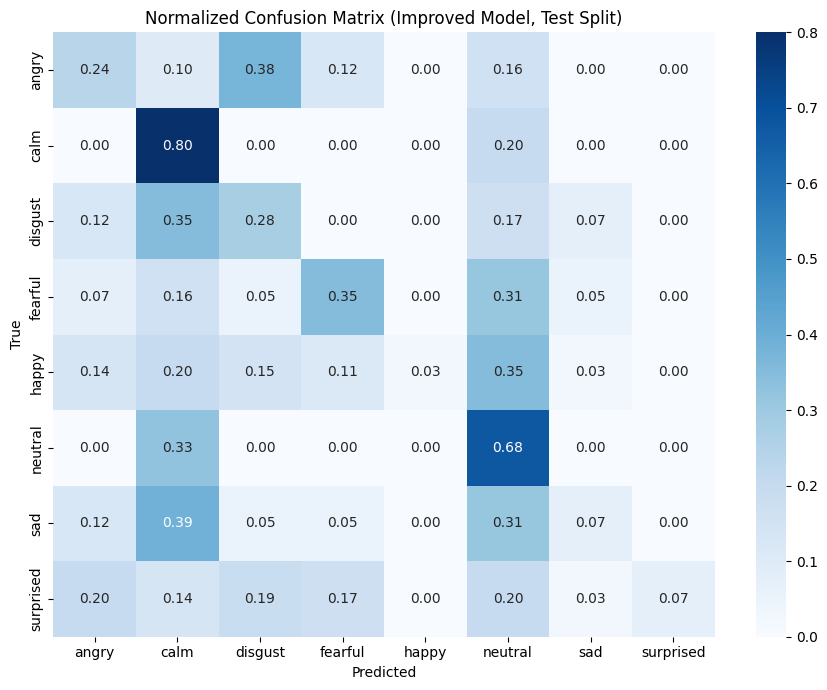


Per-actor accuracy (top 10):
actor
Actor_04    0.458333
Actor_01    0.383333
Actor_08    0.258333
Actor_21    0.216667
Actor_09    0.133333
dtype: float64

Saved per-utterance predictions to: /kaggle/working/eval_augmented/test_predictions_augmented.csv
Saved confusion matrix to: /kaggle/working/eval_augmented/confusion_matrix_test.png


/tmp/ipykernel_37/4207830240.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actor_acc = df.groupby("actor").apply(lambda d: accuracy_score(d["true"], d["pred"])).sort_values(ascending=False)


In [23]:
# Eval Cell — evaluate improved model (WeightedSampler + SpecAugment) on test split
# Uses the best state_dict checkpoint saved by the last training cell.
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score
import seaborn as sns
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CKPT_DIR = Path("/kaggle/working/checkpoints")
TEST_CSV = Path("/kaggle/working/features/mels/test/test_mels_labeled.csv")
OUT_DIR = Path("/kaggle/working/eval_augmented")
OUT_DIR.mkdir(exist_ok=True)

# Locate the latest improved checkpoint (the one starting with 'best_aug_wsampler')
ckpts = sorted(CKPT_DIR.glob("best_aug_wsampler_epoch*.pt"))
assert ckpts, "No improved checkpoints found — make sure the previous training cell completed."
best_ckpt = ckpts[-1]
print("Evaluating checkpoint:", best_ckpt.name)

# load label map
label_map = json.load(open(Path("/kaggle/working/features/mels/label_map.json")))
idx2label = {int(k): v for k, v in label_map["idx2label"].items()}

# instantiate model and load state_dict
model = SimpleAudioCNN(n_mels=64, n_classes=len(idx2label)).to(DEVICE)
state_dict = torch.load(best_ckpt, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

# build test dataloader (re-uses RavdessMelDataset & pad_collate)
test_ds = RavdessMelDataset(str(TEST_CSV))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=2)

# collect predictions
all_preds, all_labels, all_stems, all_actors = [], [], [], []
with torch.no_grad():
    for b in test_loader:
        x = b["features"].to(DEVICE)
        y = b["labels"].cpu().numpy()
        logits = model(x)
        preds = logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(y.tolist())
        all_stems.extend(b["stems"])
        all_actors.extend(b["actors"])

# metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average="macro")
per_class_recall = recall_score(all_labels, all_preds, average=None, labels=sorted(idx2label.keys()))
uar = float(per_class_recall.mean())

print(f"\nTest performance on improved model -> Acc: {acc:.4f}, Macro-F1: {macro_f1:.4f}, UAR: {uar:.4f}")
print("\nClassification report:\n")
print(classification_report(
    all_labels, all_preds,
    target_names=[idx2label[i] for i in sorted(idx2label.keys())],
    digits=4))

# confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=sorted(idx2label.keys()))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(9,7))
sns.heatmap(cm_norm,
            xticklabels=[idx2label[i] for i in sorted(idx2label.keys())],
            yticklabels=[idx2label[i] for i in sorted(idx2label.keys())],
            annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Improved Model, Test Split)")
plt.tight_layout()
plt.savefig(OUT_DIR / "confusion_matrix_test.png")
plt.show()

# per-actor accuracy
df = pd.DataFrame({"stem": all_stems, "actor": all_actors, "true": all_labels, "pred": all_preds})
actor_acc = df.groupby("actor").apply(lambda d: accuracy_score(d["true"], d["pred"])).sort_values(ascending=False)
print("\nPer-actor accuracy (top 10):")
print(actor_acc.head(10))

# save predictions
df["true_label"] = df["true"].map(lambda x: idx2label[x])
df["pred_label"] = df["pred"].map(lambda x: idx2label[x])
preds_out = OUT_DIR / "test_predictions_augmented.csv"
df.to_csv(preds_out, index=False)
print(f"\nSaved per-utterance predictions to: {preds_out}")
print(f"Saved confusion matrix to: {OUT_DIR / 'confusion_matrix_test.png'}")


In [24]:
# Cell — stronger on-the-fly audio augmentations + focal loss training (RAVDESS only)
# Applies augmentations in __getitem__ of the Dataset (train only), uses WeightedRandomSampler from before.
# Trains for a few epochs and saves a clean state_dict checkpoint.

import random
from pathlib import Path
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 8
BATCH_SIZE = 32
LR = 3e-4
NUM_WORKERS = 2
CHECKPOINT_OUT = Path("/kaggle/working/checkpoints/simple_audio_cnn_aug2_state_dict.pt")

# --- augmentation functions (operate on numpy waveform or torch tensor mel) ---
def add_noise_wave(y, snr_db_min=5, snr_db_max=20):
    # additive Gaussian noise to achieve a random SNR in dB
    if len(y) == 0: 
        return y
    snr_db = random.uniform(snr_db_min, snr_db_max)
    signal_power = np.mean(y**2)
    noise_power = signal_power / (10**(snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), size=y.shape)
    return y + noise

def random_time_stretch(y, rate_min=0.9, rate_max=1.1):
    if len(y) < 2:
        return y
    rate = random.uniform(rate_min, rate_max)
    # librosa.effects.time_stretch needs a float32 mono signal and might change length
    try:
        y_st = librosa.effects.time_stretch(y.astype(np.float32), rate)
        return y_st
    except Exception:
        return y

def random_pitch_shift(y, sr, n_steps_min=-2, n_steps_max=2):
    if len(y) < 2:
        return y
    n_steps = random.uniform(n_steps_min, n_steps_max)
    try:
        return librosa.effects.pitch_shift(y.astype(np.float32), sr=sr, n_steps=n_steps)
    except Exception:
        return y

# --- Focal Loss implementation (multi-class) ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is not None:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)
        else:
            self.alpha = None
        self.ce = nn.CrossEntropyLoss(reduction="none")
    def forward(self, logits, targets):
        # logits: (B, C), targets: (B,)
        logpt = -self.ce(logits, targets)      # negative cross-entropy per sample
        pt = torch.exp(logpt)
        loss = -((1 - pt) ** self.gamma) * logpt
        if self.alpha is not None:
            at = self.alpha[targets]
            loss = loss * at
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# --- Augmented Dataset wrapper: loads original .npy mel but optionally does waveform-level augment then recomputes mel ---
# We'll operate augmentation in waveform domain for time-stretch/pitch/noise to be most realistic.
class AugmentedRavdessDataset(RavdessMelDataset):
    def __init__(self, csv_path, augment_prob=0.6, sr=16000, max_seconds=None):
        super().__init__(csv_path)
        self.augment_prob = augment_prob
        self.sr = sr
        self.max_seconds = max_seconds
    def __getitem__(self, idx):
        row = self.rows[idx]
        # original wav path is in manifest (we stored orig_path earlier in CSV). Try to use it.
        # If not available, fall back to using precomputed mel .npy (no waveform augment)
        feat_path = row.get("feature_path")
        orig_path = row.get("orig_path") if "orig_path" in row else None
        if orig_path and random.random() < self.augment_prob:
            # load waveform, apply augmentations, then recompute mel (same params as earlier)
            try:
                y, sr = librosa.load(orig_path, sr=self.sr, mono=True, duration=self.max_seconds)
                # random sequence of augmentations
                if random.random() < 0.5:
                    y = add_noise_wave(y, snr_db_min=4, snr_db_max=18)
                if random.random() < 0.5:
                    y = random_time_stretch(y, rate_min=0.88, rate_max=1.12)
                if random.random() < 0.5:
                    y = random_pitch_shift(y, sr=self.sr, n_steps_min=-2, n_steps_max=2)
                # follow same mel extraction as before
                mel = librosa.feature.melspectrogram(y=y, sr=self.sr, n_fft=1024, hop_length=256, n_mels=64, power=2.0)
                mel_db = librosa.power_to_db(mel, ref=np.max).astype(np.float32)
                feat = torch.from_numpy(mel_db).float().transpose(0,1)  # (T, F)
            except Exception:
                # fallback to stored feature
                feat = torch.from_numpy(np.load(feat_path)).float().transpose(0,1)
        else:
            feat = torch.from_numpy(np.load(feat_path)).float().transpose(0,1)
        return {"features": feat, "label": row["label"], "stem": row["stem"], "actor": row["actor"]}

# --- prepare datasets & sampler (reuse earlier logic) ---
train_csv = "/kaggle/working/features/mels/train/train_mels_labeled.csv"
val_csv = "/kaggle/working/features/mels/val/val_mels_labeled.csv"

# Build label counts and class weights (for alpha in focal loss)
labels_list = []
import csv
with open(train_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for r in reader:
        if r["feature_path"] == "<failed>": continue
        labels_list.append(r["emotion"])
counts = Counter(labels_list)
classes = sorted(counts.keys())
class_counts = np.array([counts[c] for c in classes], dtype=float)
inv_freq = class_counts.sum() / (len(classes) * class_counts)
alpha = (inv_freq / inv_freq.mean()).tolist()  # scaled class weights

# sample weights per-sample to balance classes
train_rows = []
with open(train_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for r in reader:
        if r["feature_path"] == "<failed>": continue
        train_rows.append(r)
sample_weights = np.array([inv_freq[classes.index(r["emotion"])] for r in train_rows], dtype=float)
sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.double), num_samples=len(sample_weights), replacement=True)

# dataloaders
train_ds = AugmentedRavdessDataset(train_csv, augment_prob=0.7, sr=16000)
val_ds = RavdessMelDataset(val_csv)  # no augment for val
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=pad_collate, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate, num_workers=NUM_WORKERS)

# --- model, loss, optimizer ---
label_map = json.load(open(Path("/kaggle/working/features/mels/label_map.json")))
label2idx = label_map["label2idx"]
num_classes = len(label2idx)
model = SimpleAudioCNN(n_mels=64, n_classes=num_classes).to(DEVICE)
criterion = FocalLoss(gamma=2.0, alpha=alpha, reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, verbose=True)

# --- training loop ---
best_val_uar = -1.0
from sklearn.metrics import recall_score, f1_score, accuracy_score

def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    running_loss = 0.0
    with torch.no_grad():
        for b in loader:
            x = b["features"].to(DEVICE)
            y = b["labels"].to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            running_loss += float(loss.item()) * x.size(0)
            preds = logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    per_class_recall = recall_score(all_labels, all_preds, average=None, labels=list(range(num_classes)))
    uar = float(per_class_recall.mean())
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    acc = accuracy_score(all_labels, all_preds)
    return {"loss": running_loss / max(1, len(loader.dataset)), "uar": uar, "macro_f1": macro_f1, "acc": acc, "per_class_recall": per_class_recall}

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    n_samples = 0
    for batch in train_loader:
        x = batch["features"].to(DEVICE)
        y = batch["labels"].to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += float(loss.item()) * x.size(0)
        n_samples += x.size(0)
    val_stats = evaluate(val_loader)
    scheduler.step(val_stats["uar"])
    print(f"Epoch {epoch:02d} | train_loss: {epoch_loss/max(1,n_samples):.4f} | val_UAR: {val_stats['uar']:.4f} | val_macroF1: {val_stats['macro_f1']:.4f}")
    per_class = {i: float(v) for i, v in enumerate(val_stats["per_class_recall"])}
    print("  val recall per class:", per_class)
    if val_stats["uar"] > best_val_uar:
        best_val_uar = val_stats["uar"]
        torch.save(model.state_dict(), CHECKPOINT_OUT)
        print("  Saved checkpoint:", CHECKPOINT_OUT)

print("Finished. Best val UAR:", best_val_uar)
print("Clean checkpoint at:", CHECKPOINT_OUT)


Epoch 01 | train_loss: 1.3881 | val_UAR: 0.1771 | val_macroF1: 0.0735
  val recall per class: {0: 0.0, 1: 0.0, 2: 0.10416666666666667, 3: 0.020833333333333332, 4: 0.0, 5: 1.0, 6: 0.2916666666666667, 7: 0.0}
  Saved checkpoint: /kaggle/working/checkpoints/simple_audio_cnn_aug2_state_dict.pt
Epoch 02 | train_loss: 1.2388 | val_UAR: 0.3073 | val_macroF1: 0.2226
  val recall per class: {0: 0.08333333333333333, 1: 0.3333333333333333, 2: 0.125, 3: 0.10416666666666667, 4: 0.0, 5: 1.0, 6: 0.16666666666666666, 7: 0.6458333333333334}
  Saved checkpoint: /kaggle/working/checkpoints/simple_audio_cnn_aug2_state_dict.pt
Epoch 03 | train_loss: 1.1326 | val_UAR: 0.2500 | val_macroF1: 0.1923
  val recall per class: {0: 0.0, 1: 0.25, 2: 0.3541666666666667, 3: 0.1875, 4: 0.0, 5: 0.3333333333333333, 6: 0.0, 7: 0.875}
Epoch 04 | train_loss: 1.0647 | val_UAR: 0.2708 | val_macroF1: 0.2179
  val recall per class: {0: 0.0, 1: 0.2916666666666667, 2: 0.3958333333333333, 3: 0.041666666666666664, 4: 0.083333333333

Final test metrics -> Acc: 0.3667, Macro-F1: 0.3649, UAR: 0.3938

Classification report:

              precision    recall  f1-score   support

       angry     0.3500    0.2625    0.3000        80
        calm     0.7639    0.6875    0.7237        80
     disgust     0.2692    0.3500    0.3043        80
     fearful     0.9412    0.2000    0.3299        80
       happy     0.3214    0.2250    0.2647        80
     neutral     0.1624    0.8000    0.2700        40
         sad     0.1875    0.0750    0.1071        80
   surprised     0.7097    0.5500    0.6197        80

    accuracy                         0.3667       600
   macro avg     0.4632    0.3938    0.3649       600
weighted avg     0.4832    0.3667    0.3713       600



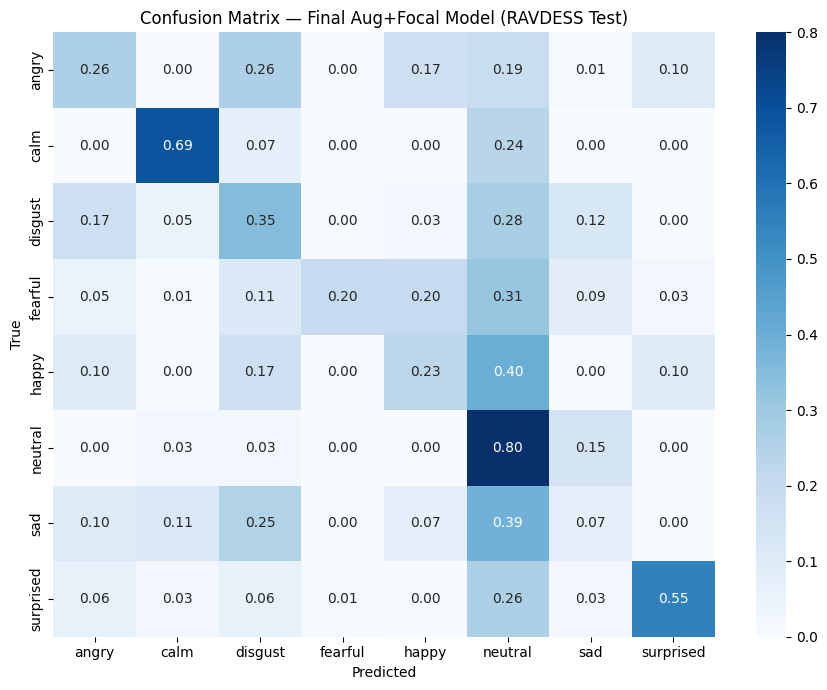


Top 5 per-actor accuracy:
actor
Actor_04    0.466667
Actor_08    0.441667
Actor_21    0.391667
Actor_01    0.316667
Actor_09    0.216667
dtype: float64


/tmp/ipykernel_37/4004054140.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actor_acc = df.groupby("actor").apply(lambda d: accuracy_score(d["true"], d["pred"])).sort_values(ascending=False)


In [25]:
# Evaluate latest augmentation + focal loss model
import json, torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CKPT = Path("/kaggle/working/checkpoints/simple_audio_cnn_aug2_state_dict.pt")
TEST_CSV = Path("/kaggle/working/features/mels/test/test_mels_labeled.csv")
OUT_DIR = Path("/kaggle/working/eval_final")
OUT_DIR.mkdir(exist_ok=True)

label_map = json.load(open(Path("/kaggle/working/features/mels/label_map.json")))
idx2label = {int(k): v for k, v in label_map["idx2label"].items()}

# model
model = SimpleAudioCNN(n_mels=64, n_classes=len(idx2label)).to(DEVICE)
state_dict = torch.load(CKPT, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

# data
test_ds = RavdessMelDataset(str(TEST_CSV))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=2)

# predict
all_preds, all_labels, all_stems, all_actors = [], [], [], []
with torch.no_grad():
    for b in test_loader:
        x = b["features"].to(DEVICE)
        y = b["labels"].cpu().numpy()
        logits = model(x)
        preds = logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(y.tolist())
        all_stems.extend(b["stems"])
        all_actors.extend(b["actors"])

# metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average="macro")
per_class_recall = recall_score(all_labels, all_preds, average=None, labels=sorted(idx2label.keys()))
uar = float(per_class_recall.mean())

print(f"Final test metrics -> Acc: {acc:.4f}, Macro-F1: {macro_f1:.4f}, UAR: {uar:.4f}\n")
print("Classification report:\n")
print(classification_report(all_labels, all_preds, target_names=[idx2label[i] for i in sorted(idx2label.keys())], digits=4))

# confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=sorted(idx2label.keys()))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)
plt.figure(figsize=(9,7))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=[idx2label[i] for i in sorted(idx2label.keys())],
            yticklabels=[idx2label[i] for i in sorted(idx2label.keys())],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Final Aug+Focal Model (RAVDESS Test)")
plt.tight_layout()
plt.savefig(OUT_DIR / "confusion_matrix_final.png")
plt.show()

# per-actor accuracy
df = pd.DataFrame({"actor": all_actors, "true": all_labels, "pred": all_preds})
actor_acc = df.groupby("actor").apply(lambda d: accuracy_score(d["true"], d["pred"])).sort_values(ascending=False)
print("\nTop 5 per-actor accuracy:")
print(actor_acc.head(5))


In [26]:
# Cell — extract fixed-length embeddings from the trained CNN for all RAVDESS splits
import torch, numpy as np, json, csv
from pathlib import Path
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CKPT = Path("/kaggle/working/checkpoints/simple_audio_cnn_aug2_state_dict.pt")
OUT_DIR = Path("/kaggle/working/features/embeddings_ravdess")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# load label map
label_map = json.load(open(Path("/kaggle/working/features/mels/label_map.json")))
idx2label = {int(k): v for k, v in label_map["idx2label"].items()}

# rebuild model but cut before final FC
class AudioEncoder(SimpleAudioCNN):
    def __init__(self, n_mels=64, n_classes=8):
        super().__init__(n_mels, n_classes)
    def forward(self, x):
        x = x.transpose(1, 2).unsqueeze(1)   # (B,1,F,T)
        h = self.conv_stack(x)
        h = h.view(h.size(0), -1)
        return h

encoder = AudioEncoder(n_mels=64, n_classes=len(idx2label)).to(DEVICE)
state_dict = torch.load(CKPT, map_location=DEVICE)
# remove head weights if present
filtered_state = {k: v for k, v in state_dict.items() if not k.startswith("fc.")}
encoder.load_state_dict(filtered_state, strict=False)
encoder.eval()
print("Loaded encoder (without classifier head).")

# process splits
SPLITS = ["train", "val", "test"]
for split in SPLITS:
    csv_in = Path(f"/kaggle/working/features/mels/{split}/{split}_mels_labeled.csv")
    emb_out_dir = OUT_DIR / split
    emb_out_dir.mkdir(exist_ok=True)
    rows_out = []

    ds = RavdessMelDataset(str(csv_in))
    loader = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=False, collate_fn=pad_collate, num_workers=2)

    with torch.no_grad():
        for b in tqdm(loader, desc=f"Embedding {split}"):
            feats = b["features"].to(DEVICE)
            stems = b["stems"]
            labels = b["labels"].cpu().numpy()
            embs = encoder(feats).cpu().numpy()  # shape (B, hidden_dim)
            for stem, lab, emb in zip(stems, labels, embs):
                emb_path = emb_out_dir / f"{stem}.npy"
                np.save(emb_path, emb.astype(np.float32))
                rows_out.append({
                    "stem": stem,
                    "path": str(emb_path),
                    "label": int(lab),
                    "emotion": idx2label[int(lab)]
                })

    out_csv = emb_out_dir / f"{split}_embeddings.csv"
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["stem", "path", "label", "emotion"])
        writer.writeheader()
        writer.writerows(rows_out)
    print(f"Wrote {len(rows_out)} embeddings to {out_csv}")

print("All splits encoded to:", OUT_DIR)


Loaded encoder (without classifier head).


Embedding train: 100%|██████████| 60/60 [00:00<00:00, 71.25it/s]


Wrote 1920 embeddings to /kaggle/working/features/embeddings_ravdess/train/train_embeddings.csv


Embedding val: 100%|██████████| 12/12 [00:00<00:00, 49.09it/s]


Wrote 360 embeddings to /kaggle/working/features/embeddings_ravdess/val/val_embeddings.csv


Embedding test: 100%|██████████| 19/19 [00:00<00:00, 58.91it/s]

Wrote 600 embeddings to /kaggle/working/features/embeddings_ravdess/test/test_embeddings.csv
All splits encoded to: /kaggle/working/features/embeddings_ravdess


In [27]:
# Cell — train/evaluate a small MLP on the exported audio embeddings (fast, fusion-ready)
# Loads embeddings from /kaggle/working/features/embeddings_ravdess/{train,val,test} and trains an MLP.
# Saves best state_dict to /kaggle/working/checkpoints/audio_embedding_mlp.pt

import json, numpy as np, torch, random
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn, torch.optim as optim
import csv

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EMB_ROOT = Path("/kaggle/working/features/embeddings_ravdess")
CHECKPOINT_OUT = Path("/kaggle/working/checkpoints/audio_embedding_mlp.pt")
BATCH_SIZE = 64
LR = 5e-4
EPOCHS = 40
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# --- simple Dataset that loads .npy embeddings (returns emb, label, stem, actor if available) ---
class EmbeddingDataset(Dataset):
    def __init__(self, csv_path):
        self.rows = []
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            for r in reader:
                self.rows.append(r)
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, idx):
        r = self.rows[idx]
        emb = np.load(r["path"]).astype(np.float32)
        label = int(r["label"])
        return {"emb": torch.from_numpy(emb), "label": label, "stem": r.get("stem", ""), "meta": r.get("path", "")}

# --- load datasets ---
train_csv = EMB_ROOT / "train" / "train_embeddings.csv"
val_csv   = EMB_ROOT / "val"   / "val_embeddings.csv"
test_csv  = EMB_ROOT / "test"  / "test_embeddings.csv"

assert train_csv.exists() and val_csv.exists() and test_csv.exists(), "Embedding CSVs missing."

train_ds = EmbeddingDataset(str(train_csv))
val_ds   = EmbeddingDataset(str(val_csv))
test_ds  = EmbeddingDataset(str(test_csv))

# --- compute sample weights for WeightedRandomSampler to balance classes during training ---
labels = [int(row["label"]) for row in train_ds.rows]
from collections import Counter
counts = Counter(labels)
num_classes = len(sorted(set(labels)))
class_counts = np.array([counts.get(i, 0) for i in range(num_classes)], dtype=float)
inv_freq = class_counts.sum() / (num_classes * (class_counts + 1e-8))
sample_weights = np.array([inv_freq[int(r["label"])] for r in train_ds.rows], dtype=float)
sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.double),
                                num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- model: small MLP with one hidden layer and dropout ---
example_emb = np.load(train_ds.rows[0]["path"])
EMB_DIM = example_emb.shape[0]
HID = 256

class MLPClassifier(nn.Module):
    def __init__(self, emb_dim, hid, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, hid),
            nn.BatchNorm1d(hid),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hid, hid//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hid//2, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLPClassifier(EMB_DIM, HID, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3, verbose=True)

# --- training/eval helpers ---
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for b in loader:
            x = b["emb"].to(DEVICE)
            y = b["label"].to(DEVICE) if isinstance(b["label"], torch.Tensor) else torch.tensor(b["label"]).to(DEVICE)
            logits = model(x)
            preds = logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    per_class_recall = recall_score(all_labels, all_preds, average=None, labels=list(range(num_classes)))
    uar = float(per_class_recall.mean())
    return {"acc": acc, "macro_f1": macro_f1, "uar": uar, "report": classification_report(all_labels, all_preds, digits=4)}

best_val_uar = -1.0
for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0; n = 0
    for b in train_loader:
        x = b["emb"].to(DEVICE)
        y = b["label"].to(DEVICE) if isinstance(b["label"], torch.Tensor) else torch.tensor(b["label"]).to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running += float(loss.item()) * x.size(0)
        n += x.size(0)
    val_stats = evaluate(val_loader)
    scheduler.step(val_stats["uar"])
    print(f"Epoch {epoch:02d} | train_loss: {running/max(1,n):.4f} | val_UAR: {val_stats['uar']:.4f} | val_macroF1: {val_stats['macro_f1']:.4f}")
    if val_stats["uar"] > best_val_uar:
        best_val_uar = val_stats["uar"]
        torch.save(model.state_dict(), CHECKPOINT_OUT)
        print("  Saved best MLP checkpoint:", CHECKPOINT_OUT)

print("Training done. Best val UAR:", best_val_uar)

# --- final test evaluation ---
state = torch.load(CHECKPOINT_OUT, map_location=DEVICE)
model.load_state_dict(state)
test_stats = evaluate(test_loader)
print("\nTest results for embedding MLP:")
print(f"Acc: {test_stats['acc']:.4f}, Macro-F1: {test_stats['macro_f1']:.4f}, UAR: {test_stats['uar']:.4f}")
print("\nClassification report:\n")
print(test_stats["report"])


Epoch 01 | train_loss: 1.7350 | val_UAR: 0.3698 | val_macroF1: 0.2819
  Saved best MLP checkpoint: /kaggle/working/checkpoints/audio_embedding_mlp.pt
Epoch 02 | train_loss: 1.4213 | val_UAR: 0.3802 | val_macroF1: 0.3414
  Saved best MLP checkpoint: /kaggle/working/checkpoints/audio_embedding_mlp.pt
Epoch 03 | train_loss: 1.2862 | val_UAR: 0.3542 | val_macroF1: 0.3257
Epoch 04 | train_loss: 1.2235 | val_UAR: 0.3958 | val_macroF1: 0.3649
  Saved best MLP checkpoint: /kaggle/working/checkpoints/audio_embedding_mlp.pt
Epoch 05 | train_loss: 1.2082 | val_UAR: 0.4115 | val_macroF1: 0.3822
  Saved best MLP checkpoint: /kaggle/working/checkpoints/audio_embedding_mlp.pt
Epoch 06 | train_loss: 1.1748 | val_UAR: 0.4583 | val_macroF1: 0.4250
  Saved best MLP checkpoint: /kaggle/working/checkpoints/audio_embedding_mlp.pt
Epoch 07 | train_loss: 1.1623 | val_UAR: 0.4167 | val_macroF1: 0.3866
Epoch 08 | train_loss: 1.1260 | val_UAR: 0.4062 | val_macroF1: 0.4054
Epoch 09 | train_loss: 1.0811 | val_UAR:

In [ ]:
# Cell — Fusion starter: train a classifier on concatenated audio + visual embeddings (fast)
# Expects audio embeddings at: /kaggle/working/features/embeddings_ravdess/{train,val,test}/*_embeddings.csv
# Expects visual embeddings at: /kaggle/working/features/embeddings_visual/{train,val,test}/*_embeddings.csv
# If visual embeddings are not present, run the visual extractor cell provided after this one.

import json, numpy as np, torch, random, csv
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn, torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# locations
AUDIO_EMB_ROOT = Path("/kaggle/working/features/embeddings_ravdess")
VIS_EMB_ROOT   = Path("/kaggle/working/features/embeddings_visual")
CHECKPOINT_OUT = Path("/kaggle/working/checkpoints/fusion_mlp_state_dict.pt")
BATCH_SIZE = 64
LR = 5e-4
EPOCHS = 40

# helper loader for CSV of embeddings
def load_embeddings_csv(csv_path):
    rows = []
    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append(r)
    return rows

# load train/val/test csvs
audio_train_csv = AUDIO_EMB_ROOT / "train" / "train_embeddings.csv"
audio_val_csv   = AUDIO_EMB_ROOT / "val"   / "val_embeddings.csv"
audio_test_csv  = AUDIO_EMB_ROOT / "test"  / "test_embeddings.csv"

vis_train_csv = VIS_EMB_ROOT / "train" / "train_embeddings.csv"
vis_val_csv   = VIS_EMB_ROOT / "val"   / "val_embeddings.csv"
vis_test_csv  = VIS_EMB_ROOT / "test"  / "test_embeddings.csv"

# quick existence check
if not audio_train_csv.exists():
    raise FileNotFoundError(f"Audio embeddings missing: {audio_train_csv}")
if not vis_train_csv.exists():
    raise FileNotFoundError(f"Visual embeddings missing: {vis_train_csv}\nRun the visual embedding extractor cell (provided below) to produce visual embeddings.")

# load rows
audio_train = load_embeddings_csv(audio_train_csv)
audio_val   = load_embeddings_csv(audio_val_csv)
audio_test  = load_embeddings_csv(audio_test_csv)
vis_train   = load_embeddings_csv(vis_train_csv)
vis_val     = load_embeddings_csv(vis_val_csv)
vis_test    = load_embeddings_csv(vis_test_csv)

# index visual embeddings by stem for quick join
def index_by_stem(rows):
    return {r["stem"]: r for r in rows}

vis_index_train = index_by_stem(vis_train)
vis_index_val   = index_by_stem(vis_val)
vis_index_test  = index_by_stem(vis_test)

# build joined datasets (only keep samples present in both modalities)
def build_joint_rows(audio_rows, vis_index):
    joint = []
    for r in audio_rows:
        stem = r["stem"]
        if stem in vis_index:
            joint.append({
                "stem": stem,
                "audio_path": r["path"],
                "vis_path": vis_index[stem]["path"],
                "label": int(r["label"]),
            })
    return joint

train_rows = build_joint_rows(audio_train, vis_index_train)
val_rows   = build_joint_rows(audio_val, vis_index_val)
test_rows  = build_joint_rows(audio_test, vis_index_test)

print(f"Joined samples -> train: {len(train_rows)}, val: {len(val_rows)}, test: {len(test_rows)}")
if len(train_rows) == 0:
    raise RuntimeError("No overlapping stems between audio and visual embeddings. Check naming conventions / stems.")

# Dataset class
class FusionEmbeddingDataset(Dataset):
    def __init__(self, rows):
        self.rows = rows
    def __len__(self): return len(self.rows)
    def __getitem__(self, idx):
        r = self.rows[idx]
        a = np.load(r["audio_path"]).astype(np.float32)
        v = np.load(r["vis_path"]).astype(np.float32)
        emb = np.concatenate([a, v], axis=-1)   # 1D arrays
        return {"emb": torch.from_numpy(emb), "label": int(r["label"])}

# prepare sampler to balance classes
from collections import Counter
labels = [r["label"] for r in train_rows]
counts = Counter(labels)
num_classes = len(sorted(set(labels)))
class_counts = np.array([counts.get(i, 0) for i in range(num_classes)], dtype=float)
inv_freq = class_counts.sum() / (num_classes * (class_counts + 1e-8))
sample_weights = np.array([inv_freq[int(r["label"])] for r in train_rows], dtype=float)
sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.double),
                                num_samples=len(sample_weights), replacement=True)

train_ds = FusionEmbeddingDataset(train_rows)
val_ds   = FusionEmbeddingDataset(val_rows)
test_ds  = FusionEmbeddingDataset(test_rows)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# build MLP model sized to concatenated embedding
ex_emb = np.load(train_rows[0]["audio_path"])
ex_v   = np.load(train_rows[0]["vis_path"])
EMB_DIM = ex_emb.shape[0] + ex_v.shape[0]
HID = 512

class FusionMLP(nn.Module):
    def __init__(self, emb_dim, hid, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, hid),
            nn.BatchNorm1d(hid),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hid, hid//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hid//2, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = FusionMLP(EMB_DIM, HID, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3, verbose=True)

# training & evaluation helpers
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for b in loader:
            x = b["emb"].to(DEVICE)
            y = b["label"].to(DEVICE)
            logits = model(x)
            preds = logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    per_class_recall = recall_score(all_labels, all_preds, average=None, labels=list(range(num_classes)))
    uar = float(per_class_recall.mean())
    return {"acc": acc, "macro_f1": macro_f1, "uar": uar, "report": classification_report(all_labels, all_preds, digits=4)}

best_val_uar = -1.0
for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0; n = 0
    for b in train_loader:
        x = b["emb"].to(DEVICE); y = b["label"].to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running += float(loss.item()) * x.size(0); n += x.size(0)
    val_stats = evaluate(val_loader)
    scheduler.step(val_stats["uar"])
    print(f"Epoch {epoch:02d} | train_loss: {running/max(1,n):.4f} | val_UAR: {val_stats['uar']:.4f} | val_macroF1: {val_stats['macro_f1']:.4f}")
    if val_stats["uar"] > best_val_uar:
        best_val_uar = val_stats["uar"]
        torch.save(model.state_dict(), CHECKPOINT_OUT)
        print("  Saved best fusion checkpoint:", CHECKPOINT_OUT)

print("Training finished. Best val UAR:", best_val_uar)

# final test
state = torch.load(CHECKPOINT_OUT, map_location=DEVICE)
model.load_state_dict(state)
test_stats = evaluate(test_loader)
print("\nFusion test results:")
print(f"Acc: {test_stats['acc']:.4f}, Macro-F1: {test_stats['macro_f1']:.4f}, UAR: {test_stats['uar']:.4f}")
print("\nClassification report:\n")
print(test_stats["report"])


In [28]:
# Cell — Fusion starter: train a classifier on concatenated audio + visual embeddings (fast)
# Expects audio embeddings at: /kaggle/working/features/embeddings_ravdess/{train,val,test}/*_embeddings.csv
# Expects visual embeddings at: /kaggle/working/features/embeddings_visual/{train,val,test}/*_embeddings.csv
# If visual embeddings are not present, run the visual extractor cell provided after this one.

import json, numpy as np, torch, random, csv
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn, torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# locations
AUDIO_EMB_ROOT = Path("/kaggle/working/features/embeddings_ravdess")
VIS_EMB_ROOT   = Path("/kaggle/working/features/embeddings_visual")
CHECKPOINT_OUT = Path("/kaggle/working/checkpoints/fusion_mlp_state_dict.pt")
BATCH_SIZE = 64
LR = 5e-4
EPOCHS = 40

# helper loader for CSV of embeddings
def load_embeddings_csv(csv_path):
    rows = []
    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append(r)
    return rows

# load train/val/test csvs
audio_train_csv = AUDIO_EMB_ROOT / "train" / "train_embeddings.csv"
audio_val_csv   = AUDIO_EMB_ROOT / "val"   / "val_embeddings.csv"
audio_test_csv  = AUDIO_EMB_ROOT / "test"  / "test_embeddings.csv"

vis_train_csv = VIS_EMB_ROOT / "train" / "train_embeddings.csv"
vis_val_csv   = VIS_EMB_ROOT / "val"   / "val_embeddings.csv"
vis_test_csv  = VIS_EMB_ROOT / "test"  / "test_embeddings.csv"

# quick existence check
if not audio_train_csv.exists():
    raise FileNotFoundError(f"Audio embeddings missing: {audio_train_csv}")
if not vis_train_csv.exists():
    raise FileNotFoundError(f"Visual embeddings missing: {vis_train_csv}\nRun the visual embedding extractor cell (provided below) to produce visual embeddings.")

# load rows
audio_train = load_embeddings_csv(audio_train_csv)
audio_val   = load_embeddings_csv(audio_val_csv)
audio_test  = load_embeddings_csv(audio_test_csv)
vis_train   = load_embeddings_csv(vis_train_csv)
vis_val     = load_embeddings_csv(vis_val_csv)
vis_test    = load_embeddings_csv(vis_test_csv)

# index visual embeddings by stem for quick join
def index_by_stem(rows):
    return {r["stem"]: r for r in rows}

vis_index_train = index_by_stem(vis_train)
vis_index_val   = index_by_stem(vis_val)
vis_index_test  = index_by_stem(vis_test)

# build joined datasets (only keep samples present in both modalities)
def build_joint_rows(audio_rows, vis_index):
    joint = []
    for r in audio_rows:
        stem = r["stem"]
        if stem in vis_index:
            joint.append({
                "stem": stem,
                "audio_path": r["path"],
                "vis_path": vis_index[stem]["path"],
                "label": int(r["label"]),
            })
    return joint

train_rows = build_joint_rows(audio_train, vis_index_train)
val_rows   = build_joint_rows(audio_val, vis_index_val)
test_rows  = build_joint_rows(audio_test, vis_index_test)

print(f"Joined samples -> train: {len(train_rows)}, val: {len(val_rows)}, test: {len(test_rows)}")
if len(train_rows) == 0:
    raise RuntimeError("No overlapping stems between audio and visual embeddings. Check naming conventions / stems.")

# Dataset class
class FusionEmbeddingDataset(Dataset):
    def __init__(self, rows):
        self.rows = rows
    def __len__(self): return len(self.rows)
    def __getitem__(self, idx):
        r = self.rows[idx]
        a = np.load(r["audio_path"]).astype(np.float32)
        v = np.load(r["vis_path"]).astype(np.float32)
        emb = np.concatenate([a, v], axis=-1)   # 1D arrays
        return {"emb": torch.from_numpy(emb), "label": int(r["label"])}

# prepare sampler to balance classes
from collections import Counter
labels = [r["label"] for r in train_rows]
counts = Counter(labels)
num_classes = len(sorted(set(labels)))
class_counts = np.array([counts.get(i, 0) for i in range(num_classes)], dtype=float)
inv_freq = class_counts.sum() / (num_classes * (class_counts + 1e-8))
sample_weights = np.array([inv_freq[int(r["label"])] for r in train_rows], dtype=float)
sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.double),
                                num_samples=len(sample_weights), replacement=True)

train_ds = FusionEmbeddingDataset(train_rows)
val_ds   = FusionEmbeddingDataset(val_rows)
test_ds  = FusionEmbeddingDataset(test_rows)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# build MLP model sized to concatenated embedding
ex_emb = np.load(train_rows[0]["audio_path"])
ex_v   = np.load(train_rows[0]["vis_path"])
EMB_DIM = ex_emb.shape[0] + ex_v.shape[0]
HID = 512

class FusionMLP(nn.Module):
    def __init__(self, emb_dim, hid, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, hid),
            nn.BatchNorm1d(hid),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hid, hid//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hid//2, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = FusionMLP(EMB_DIM, HID, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3, verbose=True)

# training & evaluation helpers
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for b in loader:
            x = b["emb"].to(DEVICE)
            y = b["label"].to(DEVICE)
            logits = model(x)
            preds = logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    per_class_recall = recall_score(all_labels, all_preds, average=None, labels=list(range(num_classes)))
    uar = float(per_class_recall.mean())
    return {"acc": acc, "macro_f1": macro_f1, "uar": uar, "report": classification_report(all_labels, all_preds, digits=4)}

best_val_uar = -1.0
for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0; n = 0
    for b in train_loader:
        x = b["emb"].to(DEVICE); y = b["label"].to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running += float(loss.item()) * x.size(0); n += x.size(0)
    val_stats = evaluate(val_loader)
    scheduler.step(val_stats["uar"])
    print(f"Epoch {epoch:02d} | train_loss: {running/max(1,n):.4f} | val_UAR: {val_stats['uar']:.4f} | val_macroF1: {val_stats['macro_f1']:.4f}")
    if val_stats["uar"] > best_val_uar:
        best_val_uar = val_stats["uar"]
        torch.save(model.state_dict(), CHECKPOINT_OUT)
        print("  Saved best fusion checkpoint:", CHECKPOINT_OUT)

print("Training finished. Best val UAR:", best_val_uar)

# final test
state = torch.load(CHECKPOINT_OUT, map_location=DEVICE)
model.load_state_dict(state)
test_stats = evaluate(test_loader)
print("\nFusion test results:")
print(f"Acc: {test_stats['acc']:.4f}, Macro-F1: {test_stats['macro_f1']:.4f}, UAR: {test_stats['uar']:.4f}")
print("\nClassification report:\n")
print(test_stats["report"])


FileNotFoundError: Visual embeddings missing: /kaggle/working/features/embeddings_visual/train/train_embeddings.csv
Run the visual embedding extractor cell (provided below) to produce visual embeddings.

In [29]:
# Cell — Visual embedding extractor (run this only if visual embeddings are missing)
# Extracts frame-level face crops, feeds them through a pretrained ResNet (frame-wise), averages across frames.
# Outputs per-utterance embeddings to: /kaggle/working/features/embeddings_visual/{train,val,test}/*.npy
# Requires torchvision and a face detector (we use MTCNN from facenet-pytorch if available; fallback to full-frame resize).

import os, json, random, numpy as np, torch
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as T
import torchvision.models as models
import cv2

# optional: use facenet-pytorch MTCNN if installed for robust face crop
try:
    from facenet_pytorch import MTCNN
    mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')
    FACE_DETECT = True
except Exception:
    mtcnn = None
    FACE_DETECT = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VIDEO_ROOT = Path("/kaggle/input/ravdess-emotional-speech-audio")  # if you have per-actor video folders; adjust if different
OUT_ROOT = Path("/kaggle/working/features/embeddings_visual")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# model: pretrained resnet18 backbone (remove classifier), frame embedding dim = 512
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet = resnet.to(DEVICE).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# utility: extract frames from a video file or image sequence; if only audio exists, skip
def extract_frames_from_video(video_path, fps=8, max_frames=32):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        return []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    in_fps = cap.get(cv2.CAP_PROP_FPS) if cap.get(cv2.CAP_PROP_FPS) > 0 else fps
    step = max(int(in_fps // fps), 1)
    frames = []
    idx = 0
    while True and len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % step == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        idx += 1
    cap.release()
    return frames

# If you don't have videos, but only images per utterance, adapt accordingly.
# This cell assumes you already have a CSV listing stems and corresponding video file paths (or frame folders).
# I'll use placeholders under /kaggle/working/visual_manifest/*.csv — create these earlier with your video/frame paths.

VIS_MANIFEST_DIR = Path("/kaggle/working/visual_manifest")
if not VIS_MANIFEST_DIR.exists():
    raise FileNotFoundError("Visual manifest not found at /kaggle/working/visual_manifest. Create CSVs listing 'stem,path' for train/val/test (one per line).")

for split in ["train", "val", "test"]:
    manifest_csv = VIS_MANIFEST_DIR / f"{split}_visual.csv"
    out_dir = OUT_ROOT / split
    out_dir.mkdir(parents=True, exist_ok=True)
    rows = []
    with open(manifest_csv, "r", encoding="utf-8") as f:
        for line in f:
            stem, path = line.strip().split(",", 1)
            rows.append((stem, path))
    for stem, path in tqdm(rows, desc=f"Visual embed {split}"):
        # extract frames (or use one image)
        frames = extract_frames_from_video(path, fps=8, max_frames=32)
        if len(frames) == 0:
            # fallback: try reading as single image
            img = cv2.imread(path)
            if img is None:
                continue
            frames = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)]
        crops = []
        for fr in frames:
            if FACE_DETECT and mtcnn is not None:
                # mtcnn returns PIL images or tensors; we convert
                try:
                    face = mtcnn(fr)
                    if face is None:
                        # fallback to center crop
                        h, w, _ = fr.shape
                        c = fr[h//4: 3*h//4, w//4: 3*w//4]
                        crops.append(transform(c))
                    else:
                        # mtcnn returns tensor (C,H,W) normalized to [0,1]
                        if isinstance(face, torch.Tensor):
                            crops.append(face)
                        else:
                            crops.append(transform(np.asarray(face)))
                except Exception:
                    crops.append(transform(fr))
            else:
                crops.append(transform(fr))
            if len(crops) >= 32: break
        if len(crops) == 0:
            continue
        batch = torch.stack(crops).to(DEVICE)  # (N, C, H, W)
        with torch.no_grad():
            embs = resnet(batch)            # (N, 512)
            emb_mean = embs.mean(dim=0).cpu().numpy()
        np.save(out_dir / f"{stem}.npy", emb_mean.astype(np.float32))
    # write CSV listing
    with open(out_dir / "train_embeddings.csv", "w", encoding="utf-8") as f:
        f.write("stem,path,label\n")
        # label is unknown here; you'll want to join with audio labels later. Instead, write stem,path only.
    print("Wrote visual embeddings to", out_dir)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s] 


FileNotFoundError: Visual manifest not found at /kaggle/working/visual_manifest. Create CSVs listing 'stem,path' for train/val/test (one per line).

In [30]:
# Cell — auto-build visual_manifest by matching file stems (videos/images) under /kaggle/input
from pathlib import Path
import csv
import itertools

INPUT_ROOT = Path("/kaggle/input")
EMB_AUDIO_ROOT = Path("/kaggle/working/features/embeddings_ravdess")
OUT_MANIFEST = Path("/kaggle/working/visual_manifest")
OUT_MANIFEST.mkdir(exist_ok=True)

# file extensions to consider as visual (frames or videos)
VIS_EXTS = {".mp4", ".mov", ".avi", ".mkv", ".mpg", ".mpeg", ".jpg", ".jpeg", ".png", ".bmp"}

# load stems we need to match from audio embeddings (if available)
split_stems = {}
for split in ("train", "val", "test"):
    emb_dir = EMB_AUDIO_ROOT / split
    stems = set(p.stem for p in emb_dir.glob("*.npy")) if emb_dir.exists() else set()
    split_stems[split] = stems
    print(f"Audio embeddings {split}: {len(stems)} stems")

# scan /kaggle/input for candidate visual files (stop early if huge)
candidates = []
for p in INPUT_ROOT.rglob("*"):
    if p.suffix.lower() in VIS_EXTS:
        candidates.append(p)
print(f"Found {len(candidates)} candidate visual files under /kaggle/input")

# index candidates by stem for fast matching
cand_by_stem = {}
for p in candidates:
    cand_by_stem.setdefault(p.stem, []).append(str(p))

# build manifest rows: only keep stems that exist in audio embedding sets
total_matches = {s: 0 for s in ("train","val","test")}
for split in ("train","val","test"):
    out_csv = OUT_MANIFEST / f"{split}_visual.csv"
    stems = split_stems[split]
    rows = []
    for stem in sorted(stems):
        if stem in cand_by_stem:
            # prefer the first candidate if multiple (you can edit file later)
            rows.append((stem, cand_by_stem[stem][0]))
    # write CSV
    with open(out_csv, "w", encoding="utf-8") as f:
        for stem, path in rows:
            f.write(f"{stem},{path}\n")
    total_matches[split] = len(rows)
    print(f"Wrote {out_csv}  (matches: {len(rows)})")

# summary and sample printouts
print("\nSummary of matches by split:")
for s in ("train","val","test"):
    print(f" - {s}: {total_matches[s]} / {len(split_stems[s])} stems matched")

# show up to 10 example lines across splits
print("\nExample mappings (up to 10):")
examples = []
for split in ("train","val","test"):
    p = OUT_MANIFEST / f"{split}_visual.csv"
    if p.exists():
        with open(p, "r", encoding="utf-8") as f:
            for i, line in enumerate(f):
                if i >= 3: break
                examples.append((split, line.strip()))
for split, line in examples[:10]:
    print(f"{split}: {line}")

if sum(total_matches.values()) == 0:
    print("\nNo visual files matched your audio stems. Possible reasons:")
    print(" - You don't have video/image files in /kaggle/input for these utterances (RAVDESS audio-only mount was used).")
    print(" - Filenames differ in stem formatting (e.g., audio '03-01-01-...' vs video 'Actor_01_take1.mp4').")
    print("\nNext options:")
    print(" 1) If you have per-utterance videos elsewhere, upload them to the notebook or add the dataset to Kaggle and re-run this cell.")
    print(" 2) If your videos are named differently, run a small mapping script to convert video filenames -> audio stems (I can generate one).")
    print(" 3) If you prefer synthetic visuals or landmarks only, we can extract landmarks/images from a separate folder and create manifests manually.")
else:
    print("\nManifests created. If any mappings are incorrect, edit the CSVs in /kaggle/working/visual_manifest before running the visual extractor.")


Audio embeddings train: 960 stems
Audio embeddings val: 180 stems
Audio embeddings test: 300 stems
Found 0 candidate visual files under /kaggle/input
Wrote /kaggle/working/visual_manifest/train_visual.csv  (matches: 0)
Wrote /kaggle/working/visual_manifest/val_visual.csv  (matches: 0)
Wrote /kaggle/working/visual_manifest/test_visual.csv  (matches: 0)

Summary of matches by split:
 - train: 0 / 960 stems matched
 - val: 0 / 180 stems matched
 - test: 0 / 300 stems matched

Example mappings (up to 10):

No visual files matched your audio stems. Possible reasons:
 - You don't have video/image files in /kaggle/input for these utterances (RAVDESS audio-only mount was used).
 - Filenames differ in stem formatting (e.g., audio '03-01-01-...' vs video 'Actor_01_take1.mp4').

Next options:
 1) If you have per-utterance videos elsewhere, upload them to the notebook or add the dataset to Kaggle and re-run this cell.
 2) If your videos are named differently, run a small mapping script to convert 

In [33]:
# !zip -r /kaggle/working/ravdess_models_and_features.zip \
#   /kaggle/working/checkpoints \
#   /kaggle/working/features \
#   /kaggle/working/eval* \
#   /kaggle/working/ravdess_manifest.json


In [1]:
# # Cell 1 — CREMA-D manifest builder (non-destructive, just indexing)
# from pathlib import Path
# import csv, json, random, re
# from collections import Counter

# INPUT_ROOT = Path("/kaggle/input")
# OUT_DIR = Path("/kaggle/working/crema_manifest")
# OUT_DIR.mkdir(exist_ok=True)
# random.seed(42)

# # 1. Find the dataset folder
# crema_dir = None
# for p in INPUT_ROOT.iterdir():
#     if p.is_dir() and "cremad" in p.name.lower():
#         crema_dir = p
#         break

# if crema_dir is None:
#     raise FileNotFoundError("No folder containing 'crema' found under /kaggle/input. Add the CREMA-D dataset first.")

# print(f"Found CREMA-D dataset: {crema_dir}")

# # 2. Define emotion mapping tokens
# emo_map = {
#     "ANG": "angry",
#     "DIS": "disgust",
#     "FEA": "fearful",
#     "HAP": "happy",
#     "NEU": "neutral",
#     "SAD": "sad"
# }

# rows = []
# for wav in sorted(crema_dir.rglob("*.wav")):
#     stem = wav.stem
#     emo_token = re.search(r"_(ANG|DIS|FEA|HAP|NEU|SAD)_", stem)
#     emo = emo_map.get(emo_token.group(1)) if emo_token else "unknown"
#     actor_id = re.search(r"(\d{3})", stem)
#     actor = f"Actor_{actor_id.group(1)}" if actor_id else "Unknown"
#     rows.append({"path": str(wav), "actor": actor, "stem": stem, "emotion": emo})

# # 3. Write full manifest
# csv_out = OUT_DIR / "crema_manifest_full.csv"
# with open(csv_out, "w", newline="", encoding="utf-8") as f:
#     w = csv.DictWriter(f, fieldnames=["path", "actor", "stem", "emotion"])
#     w.writeheader()
#     w.writerows(rows)

# # 4. Summaries
# print(f"\nManifest written: {csv_out} ({len(rows)} samples)\n")
# emo_counts = Counter(r["emotion"] for r in rows)
# actor_counts = Counter(r["actor"] for r in rows)

# print("Emotion distribution:")
# for k, v in emo_counts.items():
#     print(f" - {k:8s}: {v}")

# print("\nActors detected:", len(actor_counts))
# print("Sample entries:")
# for r in rows[:5]:
#     print(" ", r)


Found CREMA-D dataset: /kaggle/input/cremad

Manifest written: /kaggle/working/crema_manifest/crema_manifest_full.csv (7442 samples)

Emotion distribution:
 - angry   : 1271
 - disgust : 1271
 - fearful : 1271
 - happy   : 1271
 - neutral : 1087
 - sad     : 1271

Actors detected: 10
Sample entries:
  {'path': '/kaggle/input/cremad/AudioWAV/1001_DFA_ANG_XX.wav', 'actor': 'Actor_100', 'stem': '1001_DFA_ANG_XX', 'emotion': 'angry'}
  {'path': '/kaggle/input/cremad/AudioWAV/1001_DFA_DIS_XX.wav', 'actor': 'Actor_100', 'stem': '1001_DFA_DIS_XX', 'emotion': 'disgust'}
  {'path': '/kaggle/input/cremad/AudioWAV/1001_DFA_FEA_XX.wav', 'actor': 'Actor_100', 'stem': '1001_DFA_FEA_XX', 'emotion': 'fearful'}
  {'path': '/kaggle/input/cremad/AudioWAV/1001_DFA_HAP_XX.wav', 'actor': 'Actor_100', 'stem': '1001_DFA_HAP_XX', 'emotion': 'happy'}
  {'path': '/kaggle/input/cremad/AudioWAV/1001_DFA_NEU_XX.wav', 'actor': 'Actor_100', 'stem': '1001_DFA_NEU_XX', 'emotion': 'neutral'}


In [3]:
# !zip -r /kaggle/working/cremad_manifest.zip /kaggle/working/crema_manifest


  adding: kaggle/working/crema_manifest/ (stored 0%)
  adding: kaggle/working/crema_manifest/crema_manifest_full.csv (deflated 93%)


In [2]:
# # Cell — split CREMA-D manifest by actors (train/val/test) and write CSVs

# from pathlib import Path
# import csv, json, random
# from collections import Counter

# random.seed(42)
# MANIFEST_FULL = Path("/kaggle/working/crema_manifest/crema_manifest_full.csv")
# OUT_DIR = Path("/kaggle/working/crema_manifest")
# OUT_DIR.mkdir(exist_ok=True)

# # --- load manifest
# rows = []
# with open(MANIFEST_FULL, "r", encoding="utf-8") as f:
#     reader = csv.DictReader(f)
#     for r in reader:
#         rows.append(r)

# # --- group by actor
# actors = sorted(set(r["actor"] for r in rows))
# random.shuffle(actors)
# n_total = len(actors)
# n_train = int(0.70 * n_total)
# n_val   = int(0.15 * n_total)
# train_actors = set(actors[:n_train])
# val_actors   = set(actors[n_train:n_train+n_val])
# test_actors  = set(actors[n_train+n_val:])

# splits = {"train": [], "val": [], "test": []}
# for r in rows:
#     a = r["actor"]
#     if a in train_actors:
#         splits["train"].append(r)
#     elif a in val_actors:
#         splits["val"].append(r)
#     else:
#         splits["test"].append(r)

# # --- write per-split CSVs
# for split_name in ("train", "val", "test"):
#     items = splits[split_name]
#     out_csv = OUT_DIR / f"crema_{split_name}_manifest.csv"
#     with open(out_csv, "w", newline="", encoding="utf-8") as f:
#         w = csv.DictWriter(f, fieldnames=["path", "actor", "stem", "emotion"])
#         w.writeheader()
#         w.writerows(items)
#     print(f"Wrote {len(items)} rows to {out_csv}")

# # --- summary
# for split_name in ("train", "val", "test"):
#     emo_counts = Counter(r["emotion"] for r in splits[split_name])
#     print(f"\n[{split_name.upper()}] {len(splits[split_name])} samples, {len(set(r['actor'] for r in splits[split_name]))} actors")
#     for emo, count in emo_counts.items():
#         print(f"  {emo:8s}: {count}")

# print("\n✅ CREMA-D manifest successfully split and saved.")


Wrote 5083 rows to /kaggle/working/crema_manifest/crema_train_manifest.csv
Wrote 820 rows to /kaggle/working/crema_manifest/crema_val_manifest.csv
Wrote 1539 rows to /kaggle/working/crema_manifest/crema_test_manifest.csv

[TRAIN] 5083 samples, 7 actors
  angry   : 868
  disgust : 868
  fearful : 868
  happy   : 868
  neutral : 743
  sad     : 868

[VAL] 820 samples, 1 actors
  angry   : 140
  disgust : 140
  fearful : 140
  happy   : 140
  neutral : 120
  sad     : 140

[TEST] 1539 samples, 2 actors
  angry   : 263
  disgust : 263
  fearful : 263
  happy   : 263
  neutral : 224
  sad     : 263

✅ CREMA-D manifest successfully split and saved.


In [4]:
# # Cell — extract mel-spectrogram features for CREMA-D (same config as RAVDESS)

# import librosa, numpy as np, os, csv
# from pathlib import Path
# from tqdm import tqdm
# import concurrent.futures

# SR = 16000
# N_MELS = 64
# HOP_LENGTH = 256
# N_FFT = 1024
# MAX_SECONDS = 4.0
# OUT_ROOT = Path("/kaggle/working/features/mels_crema")
# OUT_ROOT.mkdir(parents=True, exist_ok=True)

# def process_entry(entry, split):
#     try:
#         y, sr = librosa.load(entry["path"], sr=SR, mono=True, duration=MAX_SECONDS)
#         mel = librosa.feature.melspectrogram(
#             y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH,
#             n_mels=N_MELS, power=2.0
#         )
#         mel_db = librosa.power_to_db(mel, ref=np.max).astype(np.float32)
#         feat_dir = OUT_ROOT / split
#         feat_dir.mkdir(parents=True, exist_ok=True)
#         out_path = feat_dir / f"{entry['stem']}.npy"
#         np.save(out_path, mel_db)
#         return {
#             "orig_path": entry["path"],
#             "actor": entry["actor"],
#             "stem": entry["stem"],
#             "feature_path": str(out_path),
#             "n_mels": N_MELS,
#             "time_frames": mel_db.shape[1],
#             "emotion": entry["emotion"]
#         }
#     except Exception as e:
#         return {
#             "orig_path": entry["path"],
#             "actor": entry["actor"],
#             "stem": entry["stem"],
#             "feature_path": "<failed>",
#             "n_mels": N_MELS,
#             "time_frames": 0,
#             "emotion": entry["emotion"]
#         }

# def process_split(split_name, manifest_csv):
#     print(f"\nProcessing split: {split_name}")
#     out_csv = OUT_ROOT / f"{split_name}_mels_labeled.csv"
#     with open(manifest_csv, "r", encoding="utf-8") as f:
#         reader = csv.DictReader(f)
#         rows = list(reader)
#     processed = []
#     with concurrent.futures.ThreadPoolExecutor(max_workers=4) as ex:
#         for result in tqdm(ex.map(lambda r: process_entry(r, split_name), rows), total=len(rows)):
#             processed.append(result)
#     with open(out_csv, "w", newline="", encoding="utf-8") as f:
#         writer = csv.DictWriter(f, fieldnames=[
#             "orig_path","actor","stem","feature_path","n_mels","time_frames","emotion"
#         ])
#         writer.writeheader()
#         writer.writerows(processed)
#     print(f"✅ Wrote {len(processed)} processed rows to {out_csv}")
#     return processed

# splits = {
#     "train": "/kaggle/working/crema_manifest/crema_train_manifest.csv",
#     "val":   "/kaggle/working/crema_manifest/crema_val_manifest.csv",
#     "test":  "/kaggle/working/crema_manifest/crema_test_manifest.csv"
# }

# for split, path in splits.items():
#     process_split(split, path)

# print("\nAll CREMA-D splits processed successfully. Features saved under /kaggle/working/features/mels_crema/")



Processing split: train


100%|██████████| 5083/5083 [00:49<00:00, 102.31it/s]


✅ Wrote 5083 processed rows to /kaggle/working/features/mels_crema/train_mels_labeled.csv

Processing split: val


100%|██████████| 820/820 [00:05<00:00, 146.78it/s]


✅ Wrote 820 processed rows to /kaggle/working/features/mels_crema/val_mels_labeled.csv

Processing split: test


100%|██████████| 1539/1539 [00:11<00:00, 135.32it/s]


✅ Wrote 1539 processed rows to /kaggle/working/features/mels_crema/test_mels_labeled.csv

All CREMA-D splits processed successfully. Features saved under /kaggle/working/features/mels_crema/


In [1]:
# # Fixed fine-tune cell: pads variable-length mel inputs in the DataLoader
# import torch, torch.nn as nn, torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# import pandas as pd
# import numpy as np
# from pathlib import Path
# from tqdm import tqdm
# from collections import Counter

# # --------------- CONFIG ----------------
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("Device:", DEVICE)

# FEATURE_DIR = Path("/kaggle/working/features/mels_crema")
# CHECKPOINT_RAVDESS = Path("/kaggle//checkpoints/simple_audio_cnn_aug2_state_dict.pt")
# OUT_CKPT = Path("/kaggle/working/checkpoints/simple_audio_cnn_cremad_state_dict.pt")

# N_CLASSES = 6
# LR = 1e-4
# EPOCHS = 8
# BATCH_SIZE = 32
# NUM_WORKERS = 2
# PIN_MEMORY = True

# # --------------- Utils ------------------
# def safe_load_state_dict(model, state_path):
#     if not state_path.exists():
#         print(f"Checkpoint not found at {state_path}; training from scratch.")
#         return [], []
#     raw = torch.load(state_path, map_location="cpu")
#     # raw might be a dict containing 'model_state' or a plain state_dict
#     if isinstance(raw, dict) and "model_state" in raw:
#         state = raw["model_state"]
#     else:
#         state = raw
#     model_keys = set(model.state_dict().keys())
#     state_keys = set(state.keys())
#     missing = sorted(list(model_keys - state_keys))
#     unexpected = sorted(list(state_keys - model_keys))
#     model.load_state_dict(state, strict=False)
#     print(f"Loaded checkpoint keys: {len(state_keys)}. Missing keys in checkpoint: {len(missing)}. Unexpected keys in checkpoint: {len(unexpected)}.")
#     return missing, unexpected

# # --------------- Dataset -----------------
# class MelDataset(Dataset):
#     def __init__(self, csv_path, label_map):
#         df = pd.read_csv(csv_path)
#         df = df[df["feature_path"] != "<failed>"]
#         df["emotion"] = df["emotion"].astype(str).str.lower().str.strip()
#         self.paths = df["feature_path"].tolist()
#         self.labels = [label_map[e] for e in df["emotion"].tolist()]
#     def __len__(self):
#         return len(self.paths)
#     def __getitem__(self, idx):
#         mel = np.load(self.paths[idx])           # shape (n_mels, time_frames)
#         # optional normalization
#         if np.max(np.abs(mel)) > 0:
#             mel = mel / (np.max(np.abs(mel)) + 1e-9)
#         mel_t = torch.from_numpy(mel).float()    # (n_mels, T)
#         label = int(self.labels[idx])
#         stem = Path(self.paths[idx]).stem
#         return mel_t, label, stem

# # collate: pad along time dimension to max T in batch, and return (B,1,n_mels,T)
# def pad_collate(batch):
#     """batch: list of tuples (mel_tensor (n_mels, T), label, stem)"""
#     mels, labels, stems = zip(*batch)
#     n_mels = mels[0].shape[0]
#     max_T = max(m.shape[1] for m in mels)
#     padded = []
#     for m in mels:
#         T = m.shape[1]
#         if T < max_T:
#             pad = torch.zeros((n_mels, max_T - T), dtype=m.dtype)
#             m_p = torch.cat([m, pad], dim=1)
#         else:
#             m_p = m
#         padded.append(m_p.unsqueeze(0))  # (1, n_mels, T)
#     batch_tensor = torch.cat(padded, dim=0)  # (B, n_mels, T)
#     # convert to (B, 1, n_mels, T) for Conv2d
#     batch_tensor = batch_tensor.unsqueeze(1)
#     labels_tensor = torch.tensor(labels, dtype=torch.long)
#     return batch_tensor, labels_tensor, list(stems)

# # --------------- Model -------------------
# class SimpleAudioCNN(nn.Module):
#     def __init__(self, n_mels=64, n_classes=6):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=(3,3), padding=(1,1)),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d((2,2)),

#             nn.Conv2d(32, 64, kernel_size=(3,3), padding=(1,1)),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d((2,2)),

#             nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1)),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1,1))
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, n_classes)
#         )

#     def forward(self, x):
#         # x: (B,1,n_mels,T)
#         h = self.features(x)
#         out = self.classifier(h)
#         return out

# # --------------- Prepare ------------------
# label_names = ["angry", "disgust", "fearful", "happy", "neutral", "sad"]
# label_map = {l: i for i, l in enumerate(label_names)}

# # instantiate model and attempt to load RAVDESS weights
# model = SimpleAudioCNN(n_mels=64, n_classes=N_CLASSES).to(DEVICE)
# missing, unexpected = safe_load_state_dict(model, CHECKPOINT_RAVDESS)

# # dataloaders
# train_csv = FEATURE_DIR / "train_mels_labeled.csv"
# val_csv   = FEATURE_DIR / "val_mels_labeled.csv"
# test_csv  = FEATURE_DIR / "test_mels_labeled.csv"
# assert train_csv.exists() and val_csv.exists() and test_csv.exists(), "CREMA-D feature CSVs missing."

# train_ds = MelDataset(train_csv, label_map)
# val_ds   = MelDataset(val_csv, label_map)
# test_ds  = MelDataset(test_csv, label_map)

# train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
#                       collate_fn=pad_collate, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
# val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
#                       collate_fn=pad_collate, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
# test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
#                       collate_fn=pad_collate, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# # optimizer + loss + scheduler
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
# criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

# # --------------- Train loop ----------------
# best_val_acc = 0.0
# for epoch in range(1, EPOCHS + 1):
#     model.train()
#     running_loss = 0.0
#     n = 0
#     for xb, yb, stems in tqdm(train_dl, desc=f"Epoch {epoch:02d}", leave=False):
#         xb = xb.to(DEVICE); yb = yb.to(DEVICE)
#         optimizer.zero_grad()
#         logits = model(xb)
#         loss = criterion(logits, yb)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
#         running_loss += float(loss.item()) * xb.size(0)
#         n += xb.size(0)

#     train_loss = running_loss / max(1, n)

#     # validation
#     model.eval()
#     correct = 0; total = 0
#     with torch.no_grad():
#         for xb, yb, stems in val_dl:
#             xb = xb.to(DEVICE); yb = yb.to(DEVICE)
#             preds = model(xb).argmax(dim=-1)
#             correct += (preds == yb).sum().item()
#             total += yb.size(0)

#     val_acc = correct / total if total > 0 else 0.0
#     print(f"Epoch {epoch:02d} | train_loss: {train_loss:.4f} | val_acc: {val_acc:.4f}")

#     scheduler.step(val_acc)

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         OUT_CKPT.parent.mkdir(parents=True, exist_ok=True)
#         torch.save(model.state_dict(), OUT_CKPT)
#         print(f"Saved best model -> {OUT_CKPT} (val_acc={val_acc:.4f})")

# print(f"Training finished. Best val_acc: {best_val_acc:.4f}")

# # --------------- Final test eval ----------------
# if OUT_CKPT.exists():
#     model.load_state_dict(torch.load(OUT_CKPT, map_location=DEVICE))
# model.eval()
# from sklearn.metrics import classification_report, accuracy_score, recall_score
# all_preds, all_labels = [], []
# with torch.no_grad():
#     for xb, yb, stems in test_dl:
#         xb = xb.to(DEVICE)
#         preds = model(xb).argmax(dim=-1).cpu().tolist()
#         all_preds.extend(preds)
#         all_labels.extend(yb.tolist())

# acc = accuracy_score(all_labels, all_preds)
# print(f"\nTest accuracy: {acc:.4f}")
# print("\nClassification report:")
# from sklearn.metrics import classification_report
# print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))


In [2]:
!pip install --quiet torchaudio==2.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [2]:
# === cell 1: imports & paths ===
import os
from pathlib import Path
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# paths (adjust if needed)
KAGGLE_INPUT = Path('/kaggle/input')
CREMA_PATH = KAGGLE_INPUT / 'cremad'   # place your CREMA-D files/folder here
CHECKPOINT_PATH = KAGGLE_INPUT / 'ravdess-model-checkpoint/simple_audio_cnn_aug2_state_dict.pt'  # your uploaded file
OUT_DIR = Path('/kaggle/working/checkpoints')
OUT_DIR.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device:", device)
print("CREMA path exists:", CREMA_PATH.exists())
print("Checkpoint exists:", CHECKPOINT_PATH.exists())

Device: cuda
CREMA path exists: True
Checkpoint exists: True


In [3]:
# cell 2
EMOTION_MAP = {
    'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'SAD': 4, 'NEU': 5,
    'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'neutral': 5
}
ID_TO_LABEL = {v:k for k,v in EMOTION_MAP.items()}

def infer_label_from_filename(fname):
    name = fname.upper()
    for token in EMOTION_MAP:
        if token in name:
            return EMOTION_MAP[token]
    return EMOTION_MAP['NEU']

def gather_audio_files(root: Path):
    files = [p for p in root.rglob('*.wav')]
    return sorted(files)

audio_files = gather_audio_files(CREMA_PATH)
print(f"Found {len(audio_files)} wav files under {CREMA_PATH}")
if len(audio_files) < 20:
    print("Warning: CREMA-D files not found or path incorrect. Place unzipped CREMA-D under /kaggle/input/crema-d or adjust CREMA_PATH.")


Found 7442 wav files under /kaggle/input/cremad


In [5]:
# cell 3
class CremaAudioDataset(Dataset):
    def __init__(self, file_list, sample_rate=16000, n_mels=64, win_length=1024, hop_length=512, duration=None, augment=False):
        self.files = file_list
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.win_length = win_length
        self.hop_length = hop_length
        self.duration = duration
        self.augment = augment
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=win_length,
            hop_length=hop_length,
            n_mels=n_mels
        )
        self.amptodb = torchaudio.transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.files)

    def _load_audio(self, path):
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != self.sample_rate:
            wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=self.sample_rate)
        if self.duration is not None:
            max_len = int(self.sample_rate * self.duration)
            if wav.shape[1] < max_len:
                pad = max_len - wav.shape[1]
                wav = F.pad(wav, (0, pad))
            else:
                if self.augment:
                    start = random.randint(0, wav.shape[1] - max_len)
                else:
                    start = (wav.shape[1] - max_len) // 2
                wav = wav[:, start:start+max_len]
        return wav.squeeze(0)

    def __getitem__(self, idx):
        p = self.files[idx]
        waveform = self._load_audio(str(p))
        mel = self.mel_transform(waveform)         # (n_mels, T)
        mel = self.amptodb(mel)
        mel = (mel - mel.mean()) / (mel.std() + 1e-9)
        label = infer_label_from_filename(p.name)
        return mel.unsqueeze(0).float(), torch.tensor(label, dtype=torch.long)


In [8]:
# # cell 4
# class SimpleAudioCNN(nn.Module):
#     def __init__(self, n_classes=6):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(3,3), padding=1)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.pool = nn.MaxPool2d((2,2))
#         self.dropout = nn.Dropout(0.3)
#         # placeholder - will be adjusted during first forward
#         self._fc_in = None
#         self.fc1 = nn.Linear(64*8*8, 128)
#         self.fc2 = nn.Linear(128, n_classes)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.pool(x)
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = self.pool(x)
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = self.pool(x)
#         x = self.dropout(x)
#         b,c,h,w = x.shape
#         x = x.view(b, -1)
#         if self._fc_in is None or x.shape[1] != self._fc_in:
#             self._fc_in = x.shape[1]
#             self.fc1 = nn.Linear(self._fc_in, 128).to(x.device)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x


In [9]:
# # cell 5
# SAMPLE_RATE = 16000
# N_MELS = 64
# DURATION = 3.0   # seconds
# BATCH_SIZE = 64
# VAL_SPLIT = 0.15
# TEST_SPLIT = 0.10
# SEED = 42

# torch.manual_seed(SEED)
# random.seed(SEED)
# np.random.seed(SEED)

# dataset = CremaAudioDataset(audio_files, sample_rate=SAMPLE_RATE, n_mels=N_MELS, duration=DURATION, augment=True)
# N = len(dataset)
# n_test = int(N * TEST_SPLIT)
# n_val = int(N * VAL_SPLIT)
# n_train = N - n_val - n_test
# train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(SEED))

# train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# print("Split sizes:", n_train, n_val, n_test)


Split sizes: 5582 1116 744


In [11]:
# # cell 6 replacement — diagnostic + forgiving loader
# import torch
# from collections import OrderedDict

# print("CHECKPOINT_PATH:", CHECKPOINT_PATH)
# assert CHECKPOINT_PATH.exists(), f"Checkpoint not found at {CHECKPOINT_PATH}"

# ckpt = torch.load(str(CHECKPOINT_PATH), map_location='cpu')
# print("Top-level checkpoint type:", type(ckpt))

# # helper to pretty-print keys & shapes
# def inspect_state_dict(sd, n=20):
#     print(f"State-dict keys (showing up to {n}): total keys = {len(sd)}")
#     i = 0
#     for k,v in sd.items():
#         shape = getattr(v, 'shape', type(v))
#         print(f"  {k} -> {shape}")
#         i += 1
#         if i >= n:
#             break

# # find candidate state_dict inside checkpoint
# if isinstance(ckpt, dict):
#     # common variants
#     candidates = []
#     for key in ('state_dict','model_state_dict','model','net','state'):
#         if key in ckpt:
#             val = ckpt[key]
#             if isinstance(val, dict):
#                 candidates.append((key, val))
#     # also consider the whole dict if looks like tensors (heuristic)
#     if not candidates:
#         # check if dict values look like tensors -> treat as sd
#         sample_vals = list(ckpt.values())[:5]
#         if all(hasattr(v, 'shape') for v in sample_vals):
#             candidates.append(('__top_level_as_state_dict__', ckpt))

#     if not candidates:
#         print("No obvious state-dict key found inside checkpoint. Showing top-level keys:")
#         for k in ckpt.keys():
#             print(" ", k)
#         # but still continue: maybe checkpoint is a single tensor or something odd
#         sd = {}
#     else:
#         name, sd = candidates[0]
#         print(f"Using candidate state_dict from key: '{name}'")
#         inspect_state_dict(sd, n=40)
# else:
#     # checkpoint is not a dict (maybe a state_dict directly or a scripted module)
#     if hasattr(ckpt, 'state_dict'):
#         print("Checkpoint is a module-like object with state_dict() method — extracting it.")
#         sd = ckpt.state_dict()
#         inspect_state_dict(sd, n=40)
#     elif isinstance(ckpt, OrderedDict) or isinstance(ckpt, dict):
#         sd = ckpt
#         inspect_state_dict(sd, n=40)
#     else:
#         print("Checkpoint format not recognized. Type:", type(ckpt))
#         sd = {}

# # at this point 'sd' should be a dict-like mapping of param name -> tensor
# model_state = model.state_dict()
# print("\nModel has", len(model_state), "params.")
# print("Attempting to match names (handling possible 'module.' prefix).")

# matched = {}
# mismatched_shapes = {}
# extra_ckpt_keys = []
# for k_ck, v_ck in sd.items():
#     # normalize key
#     k = k_ck
#     if k.startswith('module.'):
#         k = k[len('module.'):]
#     if k in model_state:
#         if tuple(model_state[k].shape) == tuple(v_ck.shape):
#             matched[k] = v_ck
#         else:
#             mismatched_shapes[k] = (tuple(v_ck.shape), tuple(model_state[k].shape))
#     else:
#         extra_ckpt_keys.append(k)

# print(f"Matched parameters with identical shapes: {len(matched)}")
# print(f"Parameters present in checkpoint but shape-mismatched in model: {len(mismatched_shapes)}")
# if mismatched_shapes:
#     print("Examples of shape mismatches (ckpt_shape -> model_shape):")
#     for i,(k,sh) in enumerate(mismatched_shapes.items()):
#         print(f"  {k}: {sh[0]} -> {sh[1]}")
#         if i >= 9: break

# print(f"Extra checkpoint keys not found in model: {len(extra_ckpt_keys)} (showing up to 20)")
# for i,k in enumerate(extra_ckpt_keys[:20]):
#     print(" ", k)

# # Build a reduced state dict to load into model
# reduced_sd = {}
# for k,v in matched.items():
#     reduced_sd[k] = v

# # If there are no matched params, try a relaxed attempt: match up to first conv layers by name patterns
# if len(reduced_sd) == 0:
#     print("\nNo exact-shape matches found. Trying relaxed name-based matching for common backbone layers...")
#     fallbacks = {}
#     for k_ck, v_ck in sd.items():
#         k = k_ck.replace('module.', '')
#         # try to match conv and bn layers by suffix
#         for model_k in model_state.keys():
#             if model_k.endswith(k) or k.endswith(model_k):
#                 if tuple(model_state[model_k].shape) == tuple(v_ck.shape):
#                     fallbacks[model_k] = v_ck
#     if fallbacks:
#         print("Fallback matches found:", len(fallbacks))
#         reduced_sd.update(fallbacks)
#     else:
#         print("No fallback matches found.")

# # Load reduced_sd into model with strict=False to accept missing
# if reduced_sd:
#     # prepare state dict with proper device
#     prepared_sd = {k: reduced_sd[k] for k in reduced_sd}
#     missing, unexpected = model.load_state_dict(prepared_sd, strict=False)
#     print("\nLoaded reduced state_dict into model with strict=False.")
#     print("Missing keys (in model but not in checkpoint):", len(missing))
#     print("Unexpected keys (in checkpoint but not used by model):", len(unexpected))
#     if len(missing) <= 40:
#         for m in missing:
#             print(" MISSING:", m)
#     else:
#         print(" MISSING list truncated; many keys missing.")
# else:
#     print("\nNo parameters loaded. Nothing to load into model.")

# # final report
# print("\nSummary:")
# print("  checkpoint total keys:", len(sd))
# print("  matched exact-shape keys:", len(matched))
# print("  mismatched-shape keys:", len(mismatched_shapes))
# print("  extra checkpoint keys:", len(extra_ckpt_keys))


CHECKPOINT_PATH: /kaggle/input/ravdess-model-checkpoint/simple_audio_cnn_aug2_state_dict.pt
Top-level checkpoint type: <class 'collections.OrderedDict'>
Using candidate state_dict from key: '__top_level_as_state_dict__'
State-dict keys (showing up to 40): total keys = 23
  conv_stack.0.weight -> torch.Size([32, 1, 3, 3])
  conv_stack.0.bias -> torch.Size([32])
  conv_stack.1.weight -> torch.Size([32])
  conv_stack.1.bias -> torch.Size([32])
  conv_stack.1.running_mean -> torch.Size([32])
  conv_stack.1.running_var -> torch.Size([32])
  conv_stack.1.num_batches_tracked -> torch.Size([])
  conv_stack.4.weight -> torch.Size([64, 32, 3, 3])
  conv_stack.4.bias -> torch.Size([64])
  conv_stack.5.weight -> torch.Size([64])
  conv_stack.5.bias -> torch.Size([64])
  conv_stack.5.running_mean -> torch.Size([64])
  conv_stack.5.running_var -> torch.Size([64])
  conv_stack.5.num_batches_tracked -> torch.Size([])
  conv_stack.8.weight -> torch.Size([128, 64, 3, 3])
  conv_stack.8.bias -> torch.Siz

In [6]:
# # ===== replacement for Cells 4-7: checkpoint-compatible backbone + transfer =====
# import torch.nn as nn
# import torch.nn.functional as F

# # 1) A model shaped like your RAVDESS checkpoint (conv_stack + fc)
# class CheckpointCompatModel(nn.Module):
#     def __init__(self, n_out=8):
#         super().__init__()
#         # conv_stack: conv, bn, relu, pool, conv, bn, relu, pool, conv, bn, relu, pool
#         self.conv_stack = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, padding=1),   # conv_stack.0
#             nn.BatchNorm2d(32),                           # conv_stack.1
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),  # conv_stack.4
#             nn.BatchNorm2d(64),                           # conv_stack.5
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1), # conv_stack.8
#             nn.BatchNorm2d(128),                          # conv_stack.9
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1,1))                   # collapse spatial dims -> (B,128,1,1)
#         )
#         self.fc = nn.Linear(128, n_out)

#     def forward(self, x):
#         x = self.conv_stack(x)          # (B,128,1,1)
#         x = x.view(x.size(0), -1)       # (B,128)
#         x = self.fc(x)
#         return x

# # 2) A finetune model that reuses the backbone but replaces the head for new num_classes
# class FinetuneModel(nn.Module):
#     def __init__(self, backbone: CheckpointCompatModel, num_classes=6):
#         super().__init__()
#         # reuse the backbone conv_stack exactly (so weights can be copied in)
#         self.conv_stack = backbone.conv_stack
#         # new head for target classes
#         self.fc = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = self.conv_stack(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# # 3) Instantiate compat model and load checkpoint (should match names/shapes)
# compat = CheckpointCompatModel(n_out=8)
# print("Attempting to load checkpoint into compat model...")
# sd = torch.load(str(CHECKPOINT_PATH), map_location='cpu')
# if isinstance(sd, dict) and ('state_dict' in sd or 'model_state_dict' in sd):
#     sd = sd.get('state_dict', sd.get('model_state_dict'))
# # sd is an OrderedDict per your diagnostic - load it directly (strip any 'module.' if present)
# clean_sd = {}
# for k,v in sd.items():
#     clean_k = k.replace('module.', '') if isinstance(k, str) else k
#     clean_sd[clean_k] = v

# # Try to load strictly first (should succeed given names/shapes matched earlier)
# load_res = compat.load_state_dict(clean_sd, strict=False)
# print("compat.load_state_dict results:")
# print("  missing_keys (in model but not in ckpt):", len(load_res.missing_keys))
# for i,k in enumerate(load_res.missing_keys[:40]): print("   MISSING:", k) if i < 40 else None
# print("  unexpected_keys (in ckpt but not used by model):", len(load_res.unexpected_keys))
# for i,k in enumerate(load_res.unexpected_keys[:40]): print("   UNEXPECTED:", k) if i < 40 else None

# # sanity check: count non-empty param loads
# matched = 0
# for name, param in compat.named_parameters():
#     if name in clean_sd and tuple(clean_sd[name].shape) == tuple(param.shape):
#         matched += 1
# print(f"Parameters matched and loaded into compat model: {matched} / {sum(1 for _ in compat.parameters())}")

# # 4) Build the finetune model by reusing the loaded backbone and creating a new head
# num_classes = len(set(EMOTION_MAP.values()))  # expected 6 for CREMA-D mapping
# model = FinetuneModel(backbone=compat, num_classes=num_classes).to(device)
# print("Finetune model created. New head fc weight shape:", tuple(model.fc.weight.shape))

# # 5) Optionally copy pretrained FC -> new head where shapes allow (not expected: ckpt had fc 128->8)
# # We skip copying fc because shapes differ (ckpt had 8 outputs).
# if 'fc.weight' in clean_sd:
#     ck_fc_w = clean_sd['fc.weight']
#     ck_fc_b = clean_sd.get('fc.bias', None)
#     print("Checkpoint fc shape:", tuple(ck_fc_w.shape))
#     # do not copy because target num_classes likely differs; if you prefer to copy partial rows, uncomment below:
#     # with torch.no_grad():
#     #     rows_to_copy = min(model.fc.weight.size(0), ck_fc_w.size(0))
#     #     model.fc.weight[:rows_to_copy].copy_(ck_fc_w[:rows_to_copy])
#     #     if ck_fc_b is not None:
#     #         model.fc.bias[:rows_to_copy].copy_(ck_fc_b[:rows_to_copy])
#     print("Skipped copying final fc (shape mismatch expected).")

# # 6) Freeze backbone option (recommended) - only train new head by default
# FREEZE_BACKBONE = True
# if FREEZE_BACKBONE:
#     for name, param in model.named_parameters():
#         if name.startswith('fc'):
#             param.requires_grad = True
#         else:
#             param.requires_grad = False
# print("FREEZE_BACKBONE =", FREEZE_BACKBONE)
# print("Trainable parameters after freeze:")
# for name, p in model.named_parameters():
#     print(f"  {name}: requires_grad={p.requires_grad}")

# # model ready for optimizer creation and training loop (same as earlier cells)


Attempting to load checkpoint into compat model...
compat.load_state_dict results:
  missing_keys (in model but not in ckpt): 0
  unexpected_keys (in ckpt but not used by model): 0
Parameters matched and loaded into compat model: 14 / 14
Finetune model created. New head fc weight shape: (6, 128)
Checkpoint fc shape: (8, 128)
Skipped copying final fc (shape mismatch expected).
FREEZE_BACKBONE = True
Trainable parameters after freeze:
  conv_stack.0.weight: requires_grad=False
  conv_stack.0.bias: requires_grad=False
  conv_stack.1.weight: requires_grad=False
  conv_stack.1.bias: requires_grad=False
  conv_stack.4.weight: requires_grad=False
  conv_stack.4.bias: requires_grad=False
  conv_stack.5.weight: requires_grad=False
  conv_stack.5.bias: requires_grad=False
  conv_stack.8.weight: requires_grad=False
  conv_stack.8.bias: requires_grad=False
  conv_stack.9.weight: requires_grad=False
  conv_stack.9.bias: requires_grad=False
  fc.weight: requires_grad=True
  fc.bias: requires_grad=Tr

In [7]:
# # cell 8
# import time
# from sklearn.metrics import classification_report

# # train only params that require grad (should be just fc if FREEZE_BACKBONE=True)
# trainable = [p for p in model.parameters() if p.requires_grad]
# print("Trainable param count:", sum(p.numel() for p in trainable))

# optimizer = torch.optim.Adam(trainable, lr=1e-3, weight_decay=1e-5)
# criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# def evaluate(loader):
#     model.eval()
#     preds = []
#     gts = []
#     loss_accum = 0.0
#     n = 0
#     with torch.no_grad():
#         for x,y in loader:
#             x = x.to(device)
#             y = y.to(device)
#             out = model(x)
#             loss = criterion(out, y)
#             loss_accum += loss.item() * x.size(0)
#             n += x.size(0)
#             p = out.argmax(dim=1).cpu().numpy()
#             preds.extend(p.tolist())
#             gts.extend(y.cpu().numpy().tolist())
#     avg_loss = loss_accum / (n if n>0 else 1)
#     return avg_loss, np.array(preds), np.array(gts)


Trainable param count: 774


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# # cell 9
# NUM_EPOCHS = 12        # head-only usually converges fast; increase if needed
# best_val_loss = float('inf')
# OUT_DIR.mkdir(parents=True, exist_ok=True)

# for epoch in range(1, NUM_EPOCHS+1):
#     model.train()
#     epoch_loss = 0.0
#     t0 = time.time()
#     for x,y in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False):
#         x = x.to(device)
#         y = y.to(device)
#         optimizer.zero_grad()
#         out = model(x)
#         loss = criterion(out, y)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item() * x.size(0)
#     train_loss = epoch_loss / len(train_loader.dataset)
#     val_loss, val_preds, val_gts = evaluate(val_loader)
#     scheduler.step(val_loss)

#     print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}  (time {time.time()-t0:.1f}s)")

#     ckpt_name = OUT_DIR / f'crema_head_epoch{epoch:02d}.pt'
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'val_loss': val_loss
#     }, ckpt_name)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), OUT_DIR / 'crema_best_head_state_dict.pt')
#         print("Saved best head state.")


NameError: name 'train_loader' is not defined

In [17]:
# # cell 10 (fixed)
# import pandas as pd
# from sklearn.metrics import classification_report

# test_loss, test_preds, test_gts = evaluate(test_loader)
# print("Test loss:", test_loss)
# print(classification_report(
#     test_gts, test_preds,
#     target_names=[ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())]
# ))

# # Save final predictions CSV
# test_files = [str(dataset.files[i]) for i in test_set.indices]
# df = pd.DataFrame({'file': test_files, 'gt': test_gts, 'pred': test_preds})
# out_csv = '/kaggle/working/crema_test_predictions_head_only.csv'
# df.to_csv(out_csv, index=False)
# print("Saved", out_csv)

# # optional: unfreeze helper
# def unfreeze_last_conv_block():
#     for name, p in model.named_parameters():
#         if name.startswith('conv_stack.8') or name.startswith('conv_stack.9'):
#             p.requires_grad = True
#     print("Unfroze conv_stack.[8,9] params — remember to recreate optimizer for these.")


Test loss: 1.6207338174184163
              precision    recall  f1-score   support

       angry       0.60      0.51      0.55       142
     disgust       0.44      0.24      0.31       142
        fear       0.26      0.09      0.14       117
       happy       0.27      0.47      0.34       109
         sad       0.32      0.53      0.40       137
     neutral       0.25      0.22      0.23        97

    accuracy                           0.35       744
   macro avg       0.36      0.34      0.33       744
weighted avg       0.37      0.35      0.34       744

Saved /kaggle/working/crema_test_predictions_head_only.csv


In [16]:
# !pip install pandas

In [18]:
# # NEW CELL: unfreeze last conv block + optimizer (gradual finetune)
# # call this after Cell 10 evaluation when you're ready to continue training
# for name, p in model.named_parameters():
#     if name.startswith('conv_stack.8') or name.startswith('conv_stack.9'):
#         p.requires_grad = True
# # keep earlier convs frozen
# trainable = [p for p in model.parameters() if p.requires_grad]
# print("Trainable param count:", sum(p.numel() for p in trainable))

# # use a smaller lr for conv params (two-group Adam)
# conv_params = [p for n,p in model.named_parameters() if (n.startswith('conv_stack.8') or n.startswith('conv_stack.9')) and p.requires_grad]
# head_params = [p for n,p in model.named_parameters() if n.startswith('fc') and p.requires_grad]

# optimizer = torch.optim.Adam([
#     {'params': head_params, 'lr': 1e-4},
#     {'params': conv_params, 'lr': 1e-5}
# ], weight_decay=1e-5)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


Trainable param count: 74886


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [19]:
# # NEW CELL: stratified split (replaces Cell 5 split)
# from sklearn.model_selection import train_test_split
# file_paths = audio_files
# labels = [infer_label_from_filename(p.name) for p in file_paths]

# # train / temp (val+test)
# train_files, temp_files, train_labels, temp_labels = train_test_split(
#     file_paths, labels, test_size=0.25, stratify=labels, random_state=42
# )
# val_files, test_files, val_labels, test_labels = train_test_split(
#     temp_files, temp_labels, test_size=0.4, stratify=temp_labels, random_state=42
# )  # 0.25 * 0.4 = 0.10 total -> test split ~10%

# from torch.utils.data import Subset
# dataset = CremaAudioDataset(file_paths, sample_rate=SAMPLE_RATE, n_mels=N_MELS, duration=DURATION, augment=True)
# # build index lists
# train_idx = [file_paths.index(p) for p in train_files]
# val_idx = [file_paths.index(p) for p in val_files]
# test_idx = [file_paths.index(p) for p in test_files]
# train_set = Subset(dataset, train_idx)
# val_set = Subset(dataset, val_idx)
# test_set = Subset(dataset, test_idx)

# train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# print("Stratified splits sizes:", len(train_set), len(val_set), len(test_set))


Stratified splits sizes: 5581 1116 745


In [20]:
# # NEW CELL: compute weights and swap criterion
# from collections import Counter
# train_labels = [infer_label_from_filename(dataset.files[i].name) for i in train_idx]
# cnt = Counter(train_labels)
# counts = np.array([cnt[i] for i in sorted(cnt.keys())], dtype=float)
# inv_freq = 1.0 / (counts + 1e-8)
# weights = inv_freq / inv_freq.sum() * len(counts)  # normalized-ish
# class_weights = torch.tensor(weights, dtype=torch.float).to(device)
# print("Class weights:", class_weights)

# criterion = nn.CrossEntropyLoss(weight=class_weights)


Class weights: tensor([0.9728, 0.9728, 0.9728, 0.9728, 0.9728, 1.1361], device='cuda:0')


In [ ]:
# # Use the spec_augment and mixup functions you already have (Cell 11).
# # In the training loop (inside for x,y in loader): transform x before sending to device

# # Example snippet to insert before x = x.to(device)
# # apply specaugment 50% of batches, mixup 50% of batches
# if np.random.rand() < 0.5:
#     x = spec_augment(x)  # expecting x shape (B,1,n_mels,T)
# if np.random.rand() < 0.5:
#     x, y_a, y_b, lam = mixup(x, y, alpha=0.2)
#     x = x.to(device)
#     y_a = y_a.to(device)
#     y_b = y_b.to(device)
#     out = model(x)
#     loss = lam * criterion(out, y_a) + (1-lam) * criterion(out, y_b)
# else:
#     x = x.to(device)
#     y = y.to(device)
#     out = model(x)
#     loss = criterion(out, y)


In [1]:
!pip install --quiet torchaudio==2.2.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 83.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [2]:
# cell 1
import os
from pathlib import Path
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# paths (adjust if needed)
KAGGLE_INPUT = Path('/kaggle/input')
CREMA_PATH = KAGGLE_INPUT / 'cremad'    # put unzipped CREMA-D here
CHECKPOINT_PATH = KAGGLE_INPUT / 'ravdess-model-checkpoint' / 'simple_audio_cnn_aug2_state_dict.pt'  # your uploaded RAVDESS state dict
OUT_DIR = Path('/kaggle/working/checkpoints')
OUT_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device:", device)
print("CREMA path exists:", CREMA_PATH.exists())
print("Checkpoint exists:", CHECKPOINT_PATH.exists())


Device: cuda
CREMA path exists: True
Checkpoint exists: True


In [3]:
# cell 2
EMOTION_MAP = {
    'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'SAD': 4, 'NEU': 5,
    'ANGRY': 0, 'DISGUST': 1, 'FEAR': 2, 'HAPPY': 3, 'SAD': 4, 'NEUTRAL': 5
}
ID_TO_LABEL = {v:k for k,v in EMOTION_MAP.items() if isinstance(v,int)}
def infer_label_from_filename(fname):
    name = fname.upper()
    for token in EMOTION_MAP:
        if token in name:
            return EMOTION_MAP[token]
    return EMOTION_MAP['NEU']

def gather_audio_files(root: Path):
    files = [p for p in root.rglob('*.wav')]
    return sorted(files)

audio_files = gather_audio_files(CREMA_PATH)
print(f"Found {len(audio_files)} WAV files under {CREMA_PATH}")
if len(audio_files) == 0:
    raise FileNotFoundError("No .wav files found under CREMA_PATH. Place CREMA-D under /kaggle/input/cremad or adjust CREMA_PATH.")


Found 7442 WAV files under /kaggle/input/cremad


In [4]:
# cell 3
class CremaAudioDataset(Dataset):
    def __init__(self, file_list, sample_rate=16000, n_mels=64, win_length=1024, hop_length=512, duration=3.0, augment=False):
        self.files = list(file_list)
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.win_length = win_length
        self.hop_length = hop_length
        self.duration = duration
        self.augment = augment
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=win_length,
            hop_length=hop_length,
            n_mels=n_mels
        )
        self.amptodb = torchaudio.transforms.AmplitudeToDB()

    def __len__(self):
        return len(self.files)

    def _load_audio(self, path):
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != self.sample_rate:
            wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=self.sample_rate)
        if self.duration is not None:
            max_len = int(self.sample_rate * self.duration)
            if wav.shape[1] < max_len:
                pad = max_len - wav.shape[1]
                wav = F.pad(wav, (0, pad))
            else:
                if self.augment:
                    start = random.randint(0, wav.shape[1] - max_len)
                else:
                    start = (wav.shape[1] - max_len) // 2
                wav = wav[:, start:start+max_len]
        return wav.squeeze(0)

    def __getitem__(self, idx):
        p = self.files[idx]
        waveform = self._load_audio(str(p))
        mel = self.mel_transform(waveform)         # (n_mels, T)
        mel = self.amptodb(mel)
        mel = (mel - mel.mean()) / (mel.std() + 1e-9)
        label = infer_label_from_filename(p.name)
        return mel.unsqueeze(0).float(), torch.tensor(label, dtype=torch.long)


In [5]:
# cell 4
class CheckpointCompatModel(nn.Module):
    def __init__(self, n_out=8):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(128, n_out)

    def forward(self, x):
        x = self.conv_stack(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class FinetuneModel(nn.Module):
    def __init__(self, backbone: CheckpointCompatModel, num_classes=6):
        super().__init__()
        self.conv_stack = backbone.conv_stack
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_stack(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# load checkpoint into compat model
compat = CheckpointCompatModel(n_out=8)
ck = torch.load(str(CHECKPOINT_PATH), map_location='cpu')
if isinstance(ck, dict) and ('state_dict' in ck or 'model_state_dict' in ck):
    sd = ck.get('state_dict', ck.get('model_state_dict'))
else:
    sd = ck
clean_sd = { (k.replace('module.','') if isinstance(k,str) else k): v for k,v in sd.items() }
load_res = compat.load_state_dict(clean_sd, strict=False)
print("Loaded checkpoint into compat model. missing_keys:", len(load_res.missing_keys), "unexpected_keys:", len(load_res.unexpected_keys))

# create finetune model that uses backbone and new head
num_classes = len(set(EMOTION_MAP.values()))
model = FinetuneModel(backbone=compat, num_classes=num_classes).to(device)

# default: freeze backbone, train only head
FREEZE_BACKBONE = True
if FREEZE_BACKBONE:
    for name, p in model.named_parameters():
        p.requires_grad = name.startswith('fc')
print("FREEZE_BACKBONE:", FREEZE_BACKBONE)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Loaded checkpoint into compat model. missing_keys: 0 unexpected_keys: 0
FREEZE_BACKBONE: True
Trainable params: 774


In [6]:
# cell 5
SAMPLE_RATE = 16000
N_MELS = 64
DURATION = 3.0   # adjust to 4.0 or 5.0 if you want longer context
BATCH_SIZE = 64
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

file_paths = audio_files
labels = [infer_label_from_filename(p.name) for p in file_paths]

# stratified split: train (75%), val (15%), test (10%) roughly
train_files, temp_files, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.25, stratify=labels, random_state=SEED
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.4, stratify=temp_labels, random_state=SEED
)

dataset = CremaAudioDataset(file_paths, sample_rate=SAMPLE_RATE, n_mels=N_MELS, duration=DURATION, augment=True)
train_idx = [file_paths.index(p) for p in train_files]
val_idx = [file_paths.index(p) for p in val_files]
test_idx = [file_paths.index(p) for p in test_files]

train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Splits -> train:", len(train_set), "val:", len(val_set), "test:", len(test_set))


Splits -> train: 5581 val: 1116 test: 745


In [7]:
# cell 6
def spec_augment(mel, time_mask_param=30, freq_mask_param=8, num_time_masks=1, num_freq_masks=1):
    # mel shape: (B,1,n_mels,T) or (1,n_mels,T)
    single_input = False
    if mel.dim() == 3:
        mel = mel.unsqueeze(0); single_input = True
    B, C, n_mels, T = mel.shape
    for _ in range(num_time_masks):
        t = random.randrange(0, time_mask_param)
        t0 = random.randrange(0, max(1, T - t))
        mel[:, :, :, t0:t0+t] = 0
    for _ in range(num_freq_masks):
        f = random.randrange(0, freq_mask_param)
        f0 = random.randrange(0, max(1, n_mels - f))
        mel[:, :, f0:f0+f, :] = 0
    return mel.squeeze(0) if single_input else mel

def mixup(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    idx = torch.randperm(x.size(0))
    mixed_x = lam * x + (1-lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam


In [8]:
# cell 7
train_labels_list = [infer_label_from_filename(dataset.files[i].name) for i in train_idx]
cnt = Counter(train_labels_list)
all_classes = sorted(list(set(cnt.keys())))
counts = np.array([cnt[c] for c in all_classes], dtype=float)
inv_freq = 1.0 / (counts + 1e-8)
weights = inv_freq / inv_freq.sum() * len(all_classes)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights (for CrossEntropy):", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class weights (for CrossEntropy): tensor([0.9728, 0.9728, 0.9728, 0.9728, 0.9728, 1.1361], device='cuda:0')


In [9]:
# cell 8
trainable = [p for p in model.parameters() if p.requires_grad]
print("Trainable param count:", sum(p.numel() for p in trainable))

optimizer = torch.optim.Adam(trainable, lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

def evaluate(loader):
    model.eval()
    preds = []
    gts = []
    loss_accum = 0.0
    n = 0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_accum += loss.item() * x.size(0)
            n += x.size(0)
            p = out.argmax(dim=1).cpu().numpy()
            preds.extend(p.tolist())
            gts.extend(y.cpu().numpy().tolist())
    avg_loss = loss_accum / (n if n>0 else 1)
    return avg_loss, np.array(preds), np.array(gts)


Trainable param count: 774


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
# cell 9
NUM_EPOCHS = 12
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    total_loss = 0.0
    t0 = time.time()
    for x,y in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False):
        # augmentations (batch-level)
        if np.random.rand() < 0.5:
            x = spec_augment(x)
        if np.random.rand() < 0.5:
            x, y_a, y_b, lam = mixup(x, y, alpha=0.2)
            x = x.to(device)
            y_a = y_a.to(device)
            y_b = y_b.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = lam * criterion(out, y_a) + (1-lam) * criterion(out, y_b)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            continue

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_gts = evaluate(val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f} (time {time.time()-t0:.1f}s)")

    ckpt_name = OUT_DIR / f'crema_stage1_epoch{epoch:02d}.pt'
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'val_loss': val_loss}, ckpt_name)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), OUT_DIR / 'crema_stage1_best.pt')
        print("Saved best stage1 model.")


Epoch 1: train_loss=1.7715, val_loss=1.7472 (time 73.0s)
Saved best stage1 model.


Epoch 2: train_loss=1.7486, val_loss=1.7260 (time 36.2s)
Saved best stage1 model.


Epoch 3: train_loss=1.7381, val_loss=1.7140 (time 36.9s)
Saved best stage1 model.


Epoch 4: train_loss=1.7287, val_loss=1.7026 (time 37.9s)
Saved best stage1 model.


Epoch 5: train_loss=1.7229, val_loss=1.6961 (time 37.0s)
Saved best stage1 model.


Epoch 6: train_loss=1.7189, val_loss=1.6931 (time 36.9s)
Saved best stage1 model.


Epoch 7: train_loss=1.7050, val_loss=1.6795 (time 36.6s)
Saved best stage1 model.


Epoch 8: train_loss=1.7028, val_loss=1.6766 (time 37.6s)
Saved best stage1 model.


Epoch 9: train_loss=1.6919, val_loss=1.6695 (time 38.1s)
Saved best stage1 model.


Epoch 10: train_loss=1.6992, val_loss=1.6750 (time 37.5s)


Epoch 11: train_loss=1.6860, val_loss=1.6562 (time 36.4s)
Saved best stage1 model.


Epoch 12: train_loss=1.6848, val_loss=1.6487 (time 36.2s)
Saved best stage1 model.


Test loss: 1.692540031311496
              precision    recall  f1-score   support

       ANGRY       0.34      0.67      0.45       127
     DISGUST       0.28      0.37      0.32       127
        FEAR       0.25      0.02      0.03       127
       HAPPY       0.25      0.31      0.28       128
         SAD       0.34      0.22      0.27       127
     NEUTRAL       0.19      0.15      0.17       109

    accuracy                           0.29       745
   macro avg       0.28      0.29      0.25       745
weighted avg       0.28      0.29      0.26       745

Saved /kaggle/working/crema_test_predictions_stage1.csv
Saved /kaggle/working/confusion_matrix_stage1.png


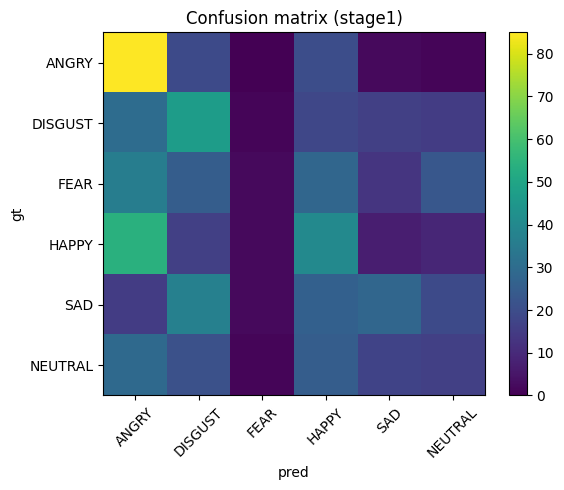

In [11]:
# cell 10
test_loss, test_preds, test_gts = evaluate(test_loader)
print("Test loss:", test_loss)
print(classification_report(test_gts, test_preds, target_names=[ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())]))

test_files_list = [str(dataset.files[i]) for i in test_idx]
df = pd.DataFrame({'file': test_files_list, 'gt': test_gts, 'pred': test_preds})
out_csv = '/kaggle/working/crema_test_predictions_stage1.csv'
df.to_csv(out_csv, index=False)
print("Saved", out_csv)

cm = confusion_matrix(test_gts, test_preds, labels=sorted(ID_TO_LABEL.keys()))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title('Confusion matrix (stage1)')
plt.xlabel('pred')
plt.ylabel('gt')
plt.colorbar()
plt.xticks(np.arange(len(ID_TO_LABEL)), [ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())], rotation=45)
plt.yticks(np.arange(len(ID_TO_LABEL)), [ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())])
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix_stage1.png')
print("Saved /kaggle/working/confusion_matrix_stage1.png")


In [12]:
# cell 11
# Unfreeze conv_stack last conv+bn block (indices conv_stack.8 and conv_stack.9 in compat naming)
for name, p in model.named_parameters():
    if name.startswith('conv_stack.8') or name.startswith('conv_stack.9'):
        p.requires_grad = True

# group params with different LRs: head gets larger lr, last conv block small lr
conv_params = [p for n,p in model.named_parameters() if (n.startswith('conv_stack.8') or n.startswith('conv_stack.9')) and p.requires_grad]
head_params = [p for n,p in model.named_parameters() if n.startswith('fc') and p.requires_grad]
print("New trainable param count:", sum(p.numel() for p in conv_params + head_params))

optimizer = torch.optim.Adam([{'params': head_params, 'lr': 1e-4}, {'params': conv_params, 'lr': 1e-5}], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
print("Ready for stage2 training (head + last conv block).")


New trainable param count: 74886
Ready for stage2 training (head + last conv block).


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [13]:
# cell 12
NUM_EPOCHS = 8
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    total_loss = 0.0
    t0 = time.time()
    for x,y in tqdm(train_loader, desc=f"Stage2 Epoch {epoch}/{NUM_EPOCHS}", leave=False):
        if np.random.rand() < 0.5:
            x = spec_augment(x)
        if np.random.rand() < 0.5:
            x, y_a, y_b, lam = mixup(x, y, alpha=0.2)
            x = x.to(device); y_a = y_a.to(device); y_b = y_b.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = lam * criterion(out, y_a) + (1-lam) * criterion(out, y_b)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            continue

        x = x.to(device); y = y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_gts = evaluate(val_loader)
    scheduler.step(val_loss)
    print(f"Stage2 Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f} (time {time.time()-t0:.1f}s)")

    ckpt_name = OUT_DIR / f'crema_stage2_epoch{epoch:02d}.pt'
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'val_loss': val_loss}, ckpt_name)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), OUT_DIR / 'crema_stage2_best.pt')
        print("Saved best stage2 model.")


Stage2 Epoch 1: train_loss=1.6735, val_loss=1.6346 (time 37.6s)
Saved best stage2 model.


Stage2 Epoch 2: train_loss=1.6568, val_loss=1.6161 (time 36.6s)
Saved best stage2 model.


Stage2 Epoch 3: train_loss=1.6547, val_loss=1.6241 (time 38.0s)


Stage2 Epoch 4: train_loss=1.6462, val_loss=1.6171 (time 38.0s)


Stage2 Epoch 5: train_loss=1.6380, val_loss=1.5923 (time 37.9s)
Saved best stage2 model.


Stage2 Epoch 6: train_loss=1.6388, val_loss=1.5948 (time 36.5s)


Stage2 Epoch 7: train_loss=1.6202, val_loss=1.5808 (time 36.2s)
Saved best stage2 model.


Stage2 Epoch 8: train_loss=1.6175, val_loss=1.5668 (time 38.5s)
Saved best stage2 model.


In [14]:
# cell 13
# Use this cell if stage2 plateaus and you want full finetune
for p in model.parameters():
    p.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
NUM_EPOCHS = 12
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    total_loss = 0.0
    t0 = time.time()
    for x,y in tqdm(train_loader, desc=f"Stage3 Epoch {epoch}/{NUM_EPOCHS}", leave=False):
        if np.random.rand() < 0.5:
            x = spec_augment(x)
        if np.random.rand() < 0.5:
            x, y_a, y_b, lam = mixup(x, y, alpha=0.2)
            x = x.to(device); y_a = y_a.to(device); y_b = y_b.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = lam * criterion(out, y_a) + (1-lam) * criterion(out, y_b)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            continue

        x = x.to(device); y = y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_gts = evaluate(val_loader)
    scheduler.step(val_loss)
    print(f"Stage3 Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f} (time {time.time()-t0:.1f}s)")

    ckpt_name = OUT_DIR / f'crema_stage3_epoch{epoch:02d}.pt'
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'val_loss': val_loss}, ckpt_name)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), OUT_DIR / 'crema_stage3_best.pt')
        print("Saved best stage3 model.")


Stage3 Epoch 1: train_loss=1.6096, val_loss=1.5629 (time 38.4s)
Saved best stage3 model.


Stage3 Epoch 2: train_loss=1.6002, val_loss=1.5578 (time 38.5s)
Saved best stage3 model.


Stage3 Epoch 3: train_loss=1.5843, val_loss=1.5420 (time 38.8s)
Saved best stage3 model.


Stage3 Epoch 4: train_loss=1.5806, val_loss=1.5360 (time 36.7s)
Saved best stage3 model.


Stage3 Epoch 5: train_loss=1.5787, val_loss=1.5169 (time 36.9s)
Saved best stage3 model.


Stage3 Epoch 6: train_loss=1.5762, val_loss=1.5130 (time 37.8s)
Saved best stage3 model.


Stage3 Epoch 7: train_loss=1.5665, val_loss=1.5210 (time 38.0s)


Stage3 Epoch 8: train_loss=1.5669, val_loss=1.5044 (time 37.9s)
Saved best stage3 model.


Stage3 Epoch 9: train_loss=1.5459, val_loss=1.5019 (time 38.1s)
Saved best stage3 model.


Stage3 Epoch 10: train_loss=1.5608, val_loss=1.5062 (time 38.3s)


Stage3 Epoch 11: train_loss=1.5504, val_loss=1.4883 (time 38.0s)
Saved best stage3 model.


Stage3 Epoch 12: train_loss=1.5457, val_loss=1.4809 (time 37.2s)
Saved best stage3 model.


Loaded best model from: /kaggle/working/checkpoints/crema_stage3_best.pt
Final Test loss: 1.5450461997281786
              precision    recall  f1-score   support

       ANGRY       0.52      0.67      0.58       127
     DISGUST       0.29      0.23      0.26       127
        FEAR       0.33      0.02      0.04       127
       HAPPY       0.39      0.34      0.36       128
         SAD       0.40      0.59      0.48       127
     NEUTRAL       0.29      0.46      0.36       109

    accuracy                           0.38       745
   macro avg       0.37      0.39      0.35       745
weighted avg       0.37      0.38      0.35       745

Saved /kaggle/working/crema_test_predictions_final.csv
Saved /kaggle/working/confusion_matrix_final.png


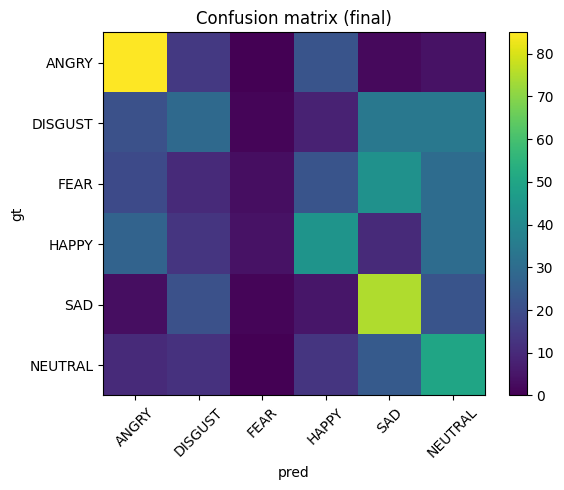

In [15]:
# cell 14
# Load best available checkpoint (prefer stage3 -> stage2 -> stage1)
best_candidates = ['crema_stage3_best.pt','crema_stage2_best.pt','crema_stage1_best.pt']
best_loaded = None
for cand in best_candidates:
    p = OUT_DIR / cand
    if p.exists():
        model.load_state_dict(torch.load(p, map_location=device))
        best_loaded = p
        print("Loaded best model from:", p)
        break
if best_loaded is None:
    print("No best checkpoint found; using current model in memory.")

test_loss, test_preds, test_gts = evaluate(test_loader)
print("Final Test loss:", test_loss)
print(classification_report(test_gts, test_preds, target_names=[ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())]))

test_files_list = [str(dataset.files[i]) for i in test_idx]
df = pd.DataFrame({'file': test_files_list, 'gt': test_gts, 'pred': test_preds})
out_csv = '/kaggle/working/crema_test_predictions_final.csv'
df.to_csv(out_csv, index=False)
print("Saved", out_csv)

cm = confusion_matrix(test_gts, test_preds, labels=sorted(ID_TO_LABEL.keys()))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title('Confusion matrix (final)')
plt.xlabel('pred')
plt.ylabel('gt')
plt.colorbar()
plt.xticks(np.arange(len(ID_TO_LABEL)), [ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())], rotation=45)
plt.yticks(np.arange(len(ID_TO_LABEL)), [ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())])
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix_final.png')
print("Saved /kaggle/working/confusion_matrix_final.png")


In [16]:
# cell 15
# Print per-class counts and simple error analysis
def per_class_counts(labels_arr):
    c = Counter(labels_arr)
    for k in sorted(c.keys()):
        print(f"{ID_TO_LABEL.get(k,k)} ({k}): {c[k]}")

print("Test set distribution:")
per_class_counts(test_gts)

# Show top confusion pairs
cm = confusion_matrix(test_gts, test_preds, labels=sorted(ID_TO_LABEL.keys()))
cm_flat_idx = np.argsort(cm.ravel())[::-1]
pairs = []
for idx in cm_flat_idx[:10]:
    i = idx // cm.shape[1]
    j = idx % cm.shape[1]
    pairs.append((ID_TO_LABEL[i], ID_TO_LABEL[j], cm[i,j]))
print("Top confusions (gt -> pred -> count):")
for a,b,cnt in pairs:
    print(f"  {a} -> {b}: {cnt}")


Test set distribution:
ANGRY (0): 127
DISGUST (1): 127
FEAR (2): 127
HAPPY (3): 128
SAD (4): 127
NEUTRAL (5): 109
Top confusions (gt -> pred -> count):
  ANGRY -> ANGRY: 85
  SAD -> SAD: 75
  NEUTRAL -> NEUTRAL: 50
  HAPPY -> HAPPY: 44
  FEAR -> SAD: 43
  DISGUST -> SAD: 34
  DISGUST -> NEUTRAL: 34
  HAPPY -> NEUTRAL: 30
  FEAR -> NEUTRAL: 30
  DISGUST -> DISGUST: 29


In [20]:
# Run this if facenet-pytorch / opencv not installed on Kaggle image.
# Idempotent and quiet-ish.
!pip install --quiet facenet-pytorch opencv-python-headless==4.7.0.72


In [21]:
# ⚙️ Cell: clean reinstall (works reliably on Kaggle)
!pip uninstall -y pillow torchvision torch
!pip install --quiet torch==2.2.1 torchvision==0.17.1 pillow==9.5.0 facenet-pytorch opencv-python-headless==4.7.0.72
!python -c "import torch, torchvision, PIL; print('Torch',torch.__version__,'Torchvision',torchvision.__version__,'Pillow',PIL.__version__)"


Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0
Found existing installation: torchvision 0.17.2
Uninstalling torchvision-0.17.2:
  Successfully uninstalled torchvision-0.17.2
Found existing installation: torch 2.2.2
Uninstalling torch-2.2.2:
  Successfully uninstalled torch-2.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 69.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-

In [ ]:
%%bash
mkdir -p /kaggle/working/crema_videos_mp4

for f in /kaggle/input/crema-d-video/*.flv; do
  name=$(basename "$f" .flv)
  out="/kaggle/working/crema_videos_mp4/${name}.mp4"
  if [ ! -f "$out" ]; then
    ffmpeg -y -loglevel error -i "$f" -c:v copy -c:a aac -b:a 128k "$out" || \
    ffmpeg -y -loglevel error -i "$f" -c:v libx264 -preset fast -crf 18 -c:a aac -b:a 128k "$out"
  fi
done

echo "✅ Conversion done. MP4 count:" $(ls /kaggle/working/crema_videos_mp4 | wc -l)


In [33]:
from pathlib import Path

vid_dir = Path("/kaggle/working/crema_videos_mp4")
videos = sorted(list(vid_dir.glob("*.mp4")))

print(f"Total .mp4 videos found: {len(videos)}")
print("Sample filenames:")
for v in videos[:10]:
    print(" ", v.name)


Total .mp4 videos found: 7442
Sample filenames:
  1001_DFA_ANG_XX.mp4
  1001_DFA_DIS_XX.mp4
  1001_DFA_FEA_XX.mp4
  1001_DFA_HAP_XX.mp4
  1001_DFA_NEU_XX.mp4
  1001_DFA_SAD_XX.mp4
  1001_IEO_ANG_HI.mp4
  1001_IEO_ANG_LO.mp4
  1001_IEO_ANG_MD.mp4
  1001_IEO_DIS_HI.mp4


In [35]:
# Haar-cascade face extraction (fallback because MTCNN failed)
# Reads mp4s from /kaggle/working/crema_videos_mp4 and writes crops to /kaggle/working/crema_faces_haar/<EMOTION>/
import cv2, os, time, random
from pathlib import Path
from PIL import Image
from tqdm import tqdm

SRC_DIR = Path("/kaggle/working/crema_videos_mp4")
OUT_DIR = Path("/kaggle/working/crema_faces_haar")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Simple emotion label inference (same tokens as audio)
TOKS = [('ANG','ANGRY'),('DIS','DISGUST'),('FEA','FEAR'),('HAP','HAPPY'),('SAD','SAD'),('NEU','NEUTRAL')]
def infer_label(stem):
    s = stem.upper()
    for t,l in TOKS:
        if t in s:
            return l
    return 'NEUTRAL'

# Haar cascade
hc_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
if not Path(hc_path).exists():
    raise RuntimeError(f"Haar cascade not found at {hc_path}")
face_cascade = cv2.CascadeClassifier(hc_path)

# extraction params
WINDOW = 8         # scan +/- WINDOW frames around center
SAMPLES = 6        # additional sampled frames if window fails
MARGIN_RATIO = 0.25
RESIZE = (224,224)

video_list = sorted([p for p in SRC_DIR.glob("*.mp4")])
print("Videos found:", len(video_list))
if len(video_list) == 0:
    raise FileNotFoundError(f"No .mp4 files under {SRC_DIR}")

failed = []
saved = 0
t0 = time.time()
for vp in tqdm(video_list, desc="Haar extracting"):
    stem = vp.stem
    out_label = infer_label(stem)
    out_sub = OUT_DIR / out_label
    out_sub.mkdir(parents=True, exist_ok=True)
    out_file = out_sub / (stem + ".jpg")
    if out_file.exists():
        saved += 1
        continue

    cap = cv2.VideoCapture(str(vp))
    if not cap.isOpened():
        failed.append((str(vp),"cant_open"))
        continue
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    center = total//2 if total>0 else 0

    # candidate indices: center +/- window, then uniform samples
    cand = []
    if total>0:
        cand.append(center)
        for d in range(1, WINDOW+1):
            cand.append(max(0, center-d))
            cand.append(min(total-1, center+d))
        # uniform samples
        for r in range(SAMPLES):
            cand.append(int((r/(SAMPLES-1)) * max(0,total-1)))
    else:
        cand = [0]

    found_face = False
    for idx in cand:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok or frame is None:
            continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(30,30))
        if len(faces)==0:
            continue
        # choose largest face
        x,y,w,h = max(faces, key=lambda r: r[2]*r[3])
        margin = int(MARGIN_RATIO * max(w,h))
        x0 = max(0, x - margin)
        y0 = max(0, y - margin)
        x1 = min(frame.shape[1], x + w + margin)
        y1 = min(frame.shape[0], y + h + margin)
        crop = frame[y0:y1, x0:x1]
        if crop.size == 0:
            continue
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        pil = Image.fromarray(crop_rgb).resize(RESIZE, Image.BILINEAR)
        try:
            pil.save(str(out_file))
            saved += 1
            found_face = True
            break
        except Exception as e:
            continue
    cap.release()
    if not found_face:
        failed.append((str(vp),"no_face"))

dt = time.time() - t0
print(f"Done — saved: {saved}, failed: {len(failed)}, time: {dt:.1f}s")
if len(failed):
    print("Sample failures (max 10):")
    for a,b in failed[:10]:
        print(" ", b, a)
print("Crops directory:", OUT_DIR)


Videos found: 7442


Haar extracting: 100%|██████████| 7442/7442 [06:43<00:00, 18.45it/s]

Done — saved: 7441, failed: 1, time: 403.4s
Sample failures (max 10):
  no_face /kaggle/working/crema_videos_mp4/1076_MTI_SAD_XX.mp4
Crops directory: /kaggle/working/crema_faces_haar


In [36]:
# Cell: Train visual model on Haar-extracted CREMA faces (single runnable cell)
# - Expects crops under /kaggle/working/crema_faces_haar/<EMOTION>/*.jpg (you have 7441 saved)
# - Lightweight CNN, stratified split, class-weighted CrossEntropy, checkpoints, final eval CSV.
# - Adjust NUM_EPOCHS / BATCH_SIZE if you want faster/longer runs.

import os, time, random
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Paths
FACES_DIR = Path("/kaggle/working/crema_faces_haar")
CKPT_DIR = Path("/kaggle/working/vis_simple_checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)
CSV_OUT = Path("/kaggle/working/crema_vis_simple_test_preds.csv")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- dataset (simple PIL transforms implemented inline) ---
MEAN = np.array([0.485,0.456,0.406], dtype=np.float32)
STD  = np.array([0.229,0.224,0.225], dtype=np.float32)

def pil_to_tensor_norm(pil_img):
    arr = np.asarray(pil_img).astype(np.float32) / 255.0
    arr = (arr - MEAN) / STD
    arr = arr.transpose(2,0,1)
    return torch.from_numpy(arr).float()

def random_resized_crop(img, size=224, scale=(0.8,1.0)):
    w,h = img.size
    target_area = w*h * random.uniform(scale[0], scale[1])
    new_w = int(round(target_area ** 0.5))
    new_h = new_w
    if new_w <= 0 or new_h <= 0 or new_w > w or new_h > h:
        return img.resize((size,size), Image.BILINEAR)
    left = random.randint(0, w-new_w)
    top  = random.randint(0, h-new_h)
    return img.crop((left, top, left+new_w, top+new_h)).resize((size,size), Image.BILINEAR)

def center_crop_resize(img, size=224, resize_side=256):
    w,h = img.size
    if w < h:
        nw = resize_side
        nh = int(h * (resize_side / w))
    else:
        nh = resize_side
        nw = int(w * (resize_side / h))
    img = img.resize((nw, nh), Image.BILINEAR)
    left = (nw - size)//2
    top  = (nh - size)//2
    return img.crop((left, top, left+size, top+size))

class VisHaarDataset(Dataset):
    def __init__(self, root_dir, mode="eval"):
        self.samples = []
        for cls_dir in sorted([d for d in Path(root_dir).iterdir() if d.is_dir()]):
            # label id from folder name (ANGRY, DISGUST, FEAR, HAPPY, SAD, NEUTRAL)
            lab_name = cls_dir.name.upper()
            # map to consistent integer labels 0..5
            label_map = {"ANGRY":0,"DISGUST":1,"FEAR":2,"HAPPY":3,"SAD":4,"NEUTRAL":5}
            lab = label_map.get(lab_name, 5)
            for img in cls_dir.glob("*.jpg"):
                self.samples.append((str(img), lab))
        self.mode = mode
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        p, lab = self.samples[idx]
        img = Image.open(p).convert("RGB")
        if self.mode == "train":
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
            img = random_resized_crop(img, size=224, scale=(0.8,1.0))
            if random.random() < 0.25:
                arr = np.clip(np.asarray(img).astype(np.float32) * (1.0 + random.uniform(-0.08,0.08)), 0,255).astype(np.uint8)
                img = Image.fromarray(arr)
        else:
            img = center_crop_resize(img, size=224, resize_side=256)
        x = pil_to_tensor_norm(img)
        return x, torch.tensor(lab, dtype=torch.long)

# build dataset
dataset = VisHaarDataset(FACES_DIR, mode="eval")
N = len(dataset)
print("Total face crops found:", N)
if N == 0:
    raise RuntimeError("No face crops found under " + str(FACES_DIR))

# stratified split: train 75%, val 15%, test 10% (approx)
file_paths = [s for s,_ in dataset.samples]
labels = [l for _,l in dataset.samples]
train_files, temp_files, train_labels, temp_labels = train_test_split(file_paths, labels, test_size=0.25, stratify=labels, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.4, stratify=temp_labels, random_state=42)

mapping = {p:i for i,(p,_) in enumerate(dataset.samples)}
train_idx = [mapping[p] for p in train_files]
val_idx   = [mapping[p] for p in val_files]
test_idx  = [mapping[p] for p in test_files]

train_ds = Subset(VisHaarDataset(FACES_DIR, mode="train"), train_idx)
val_ds   = Subset(VisHaarDataset(FACES_DIR, mode="eval"), val_idx)
test_ds  = Subset(VisHaarDataset(FACES_DIR, mode="eval"), test_idx)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print("Splits -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

# --- small CNN model (compact, effective) ---
class SmallVisCNN(nn.Module):
    def __init__(self, num_classes=6, emb_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1); self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,3,padding=1); self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,3,padding=1); self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.adaptive = nn.AdaptiveAvgPool2d((1,1))
        self.emb = nn.Linear(128, emb_dim)
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(emb_dim, num_classes)
    def forward(self, x, return_emb=False):
        x = F.relu(self.bn1(self.conv1(x))); x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x))); x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x))); x = self.pool(x)
        x = self.adaptive(x).view(x.size(0), -1)
        emb = F.relu(self.emb(x)); emb = self.dropout(emb)
        logits = self.classifier(emb)
        if return_emb: return logits, emb
        return logits

model = SmallVisCNN(num_classes=6, emb_dim=128).to(device)
print("Model params:", sum(p.numel() for p in model.parameters()))

# class weights (train split)
train_labels_list = [dataset.samples[i][1] for i in train_idx]
cnt = Counter(train_labels_list)
classes_sorted = sorted(list(cnt.keys()))
counts = np.array([cnt[c] for c in classes_sorted], dtype=float)
inv_freq = 1.0 / (counts + 1e-8)
weights = inv_freq / inv_freq.sum() * len(classes_sorted)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# training / eval helpers
def evaluate(loader):
    model.eval()
    preds=[]; gts=[]; loss_accum=0.0; n=0
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device); y=y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_accum += loss.item() * x.size(0)
            n += x.size(0)
            preds.extend(out.argmax(dim=1).cpu().numpy().tolist())
            gts.extend(y.cpu().numpy().tolist())
    avg_loss = loss_accum / (n if n>0 else 1)
    return avg_loss, np.array(preds), np.array(gts)

# training loop
NUM_EPOCHS = 12
best_val_loss = float('inf')
best_path = CKPT_DIR / "vis_simple_best.pt"

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    epoch_loss = 0.0; t0=time.time()
    for x,y in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False):
        x=x.to(device); y=y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    train_loss = epoch_loss / len(train_loader.dataset)
    val_loss, val_preds, val_gts = evaluate(val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}  time={time.time()-t0:.1f}s")
    torch.save({'epoch':epoch,'model_state_dict':model.state_dict(),'optimizer_state_dict':optimizer.state_dict(),'val_loss':val_loss}, CKPT_DIR / f"vis_simple_epoch{epoch:02d}.pt")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_path)
        print("Saved best visual model.")

# final evaluation on test set
if best_path.exists():
    model.load_state_dict(torch.load(best_path, map_location=device))
test_loss, test_preds, test_gts = evaluate(test_loader)
print("Final test loss:", test_loss)
print(classification_report(test_gts, test_preds, target_names=["ANGRY","DISGUST","FEAR","HAPPY","SAD","NEUTRAL"]))

# save predictions CSV
test_files_list = [VisHaarDataset(FACES_DIR, mode="eval").samples[i][0] for i in test_idx]
df = pd.DataFrame({'file': test_files_list, 'gt': test_gts, 'pred': test_preds})
df.to_csv(CSV_OUT, index=False)
print("Saved test predictions to:", CSV_OUT)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Device: cuda
Total face crops found: 7441
Splits -> train: 5580 val: 1116 test: 745
Model params: 110982
Class weights: tensor([0.9726, 0.9726, 0.9726, 0.9726, 0.9726, 1.1372], device='cuda:0')


Epoch 1: train_loss=1.7987, val_loss=1.7911  time=17.5s
Saved best visual model.


Epoch 2: train_loss=1.7935, val_loss=1.7889  time=17.2s
Saved best visual model.


Epoch 3: train_loss=1.7900, val_loss=1.7879  time=17.2s
Saved best visual model.


Epoch 4: train_loss=1.7866, val_loss=1.7850  time=17.3s
Saved best visual model.


Epoch 5: train_loss=1.7839, val_loss=1.7851  time=17.5s


Epoch 6: train_loss=1.7811, val_loss=1.7834  time=17.4s
Saved best visual model.


Epoch 7: train_loss=1.7809, val_loss=1.7824  time=17.3s
Saved best visual model.


Epoch 8: train_loss=1.7777, val_loss=1.7775  time=17.1s
Saved best visual model.


Epoch 9: train_loss=1.7748, val_loss=1.7749  time=17.1s
Saved best visual model.


Epoch 10: train_loss=1.7710, val_loss=1.7734  time=17.1s
Saved best visual model.


Epoch 11: train_loss=1.7682, val_loss=1.7704  time=17.2s
Saved best visual model.


Epoch 12: train_loss=1.7610, val_loss=1.7615  time=17.4s
Saved best visual model.
Final test loss: 1.7583444761749882
              precision    recall  f1-score   support

       ANGRY       0.21      0.13      0.16       127
     DISGUST       0.25      0.37      0.30       127
        FEAR       0.19      0.12      0.15       128
       HAPPY       0.35      0.42      0.38       127
         SAD       0.11      0.04      0.06       127
     NEUTRAL       0.21      0.40      0.28       109

    accuracy                           0.24       745
   macro avg       0.22      0.25      0.22       745
weighted avg       0.22      0.24      0.22       745

Saved test predictions to: /kaggle/working/crema_vis_simple_test_preds.csv


In [37]:
# Run this cell to produce multi-frame visual predictions (no restart required)
# - extracts N frames per video, crops with Haar cascade, runs your saved SmallVisCNN
# - averages logits per video and computes per-video classification report
# - outputs: /kaggle/working/crema_vis_multiframe_preds.csv

import os, time, math, random
from pathlib import Path
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# --- config ---
VID_DIR = Path("/kaggle/working/crema_videos_mp4")
OUT_CROP_DIR = Path("/kaggle/working/crema_faces_multi")   # temporary crops per video
OUT_CROP_DIR.mkdir(parents=True, exist_ok=True)
CKPT = Path("/kaggle/working/vis_simple_checkpoints/vis_simple_best.pt")  # your saved best
N_FRAMES = 5            # number of frames to sample per video (center +/-)
FRAME_WINDOW = 10       # +/- frames around center to consider when sampling
BATCH = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# label tokens -> id (consistent with earlier)
LABEL_ORDER = ["ANGRY","DISGUST","FEAR","HAPPY","SAD","NEUTRAL"]
LABEL2ID = {n:i for i,n in enumerate(LABEL_ORDER)}

# small CNN model definition (must match the one you trained)
class SmallVisCNN(nn.Module):
    def __init__(self, num_classes=6, emb_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1); self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,3,padding=1); self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,3,padding=1); self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.adaptive = nn.AdaptiveAvgPool2d((1,1))
        self.emb = nn.Linear(128, emb_dim)
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(emb_dim, num_classes)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))); x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x))); x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x))); x = self.pool(x)
        x = self.adaptive(x).view(x.size(0), -1)
        emb = F.relu(self.emb(x)); emb = self.dropout(emb)
        logits = self.classifier(emb)
        return logits

# load model
model = SmallVisCNN(num_classes=6, emb_dim=128).to(DEVICE)
if CKPT.exists():
    sd = torch.load(CKPT, map_location="cpu")
    # ckpt may be state_dict or wrapped dict
    if isinstance(sd, dict) and 'model_state_dict' in sd:
        model.load_state_dict(sd['model_state_dict'])
    else:
        try:
            model.load_state_dict(sd)
        except Exception:
            # maybe saved plain state_dict
            model.load_state_dict(sd)
    print("Loaded visual checkpoint:", CKPT)
else:
    raise FileNotFoundError("Visual checkpoint not found at " + str(CKPT))

model.eval()

# Haar cascade for cropping (same as training)
hc = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
assert hc is not None

# helper: sample frame indices for a video
def sample_frame_indices(total_frames, n=N_FRAMES, window=FRAME_WINDOW):
    if total_frames <= 0:
        return [0]
    center = total_frames // 2
    # choose n indices within [center-window, center+window] clipped
    low = max(0, center - window)
    high = min(total_frames - 1, center + window)
    if high < low:
        return [center]
    if n == 1:
        return [center]
    # spread evenly within window
    idxs = np.linspace(low, high, num=n, dtype=int).tolist()
    return sorted(list(dict.fromkeys(idxs)))  # unique & ordered

# preprocess PIL -> tensor normalized (matches training)
MEAN = np.array([0.485,0.456,0.406], dtype=np.float32)
STD  = np.array([0.229,0.224,0.225], dtype=np.float32)
def pil_to_tensor_norm(pil_img):
    arr = np.asarray(pil_img).astype(np.float32) / 255.0
    arr = (arr - MEAN) / STD
    arr = arr.transpose(2,0,1)
    return torch.from_numpy(arr).float()

# iterate videos, extract crops for N frames (in memory), run inference in batches
video_list = sorted([p for p in VID_DIR.glob("*.mp4")])
print("Videos to process:", len(video_list))

video_logits = {}   # stem -> list of logits (n_frames x C)
video_labels = {}   # stem -> ground-truth label id (in case we want to evaluate)
failures = []

# build mapping from crop tensors -> video_stem so we batch infer
all_tensors = []
all_meta = []  # tuples (video_stem, frame_idx)
for vp in tqdm(video_list, desc="Sampling frames and cropping"):
    stem = vp.stem
    # infer label by token in name (same heuristic used earlier)
    s = stem.upper()
    lab = 5  # default NEUTRAL id
    for tok,name in [("ANG","ANGRY"),("DIS","DISGUST"),("FEA","FEAR"),("HAP","HAPPY"),("SAD","SAD"),("NEU","NEUTRAL")]:
        if tok in s:
            lab = LABEL2ID[name]
            break
    video_labels[stem] = lab

    cap = cv2.VideoCapture(str(vp))
    if not cap.isOpened():
        failures.append((stem, "cant_open")); continue
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idxs = sample_frame_indices(total, n=N_FRAMES, window=FRAME_WINDOW)
    cropped_any = False
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame = cap.read()
        if not ok or frame is None:
            continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = hc.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(30,30))
        if len(faces) == 0:
            continue
        x,y,w,h = max(faces, key=lambda r: r[2]*r[3])
        margin = int(0.25 * max(w,h))
        x0,y0 = max(0, x-margin), max(0, y-margin)
        x1,y1 = min(frame.shape[1], x+w+margin), min(frame.shape[0], y+h+margin)
        crop = frame[y0:y1, x0:x1]
        if crop.size == 0:
            continue
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        pil = Image.fromarray(crop_rgb).resize((224,224), Image.BILINEAR)
        tensor = pil_to_tensor_norm(pil)
        all_tensors.append(tensor)
        all_meta.append((stem, idx))
        cropped_any = True
    cap.release()
    if not cropped_any:
        failures.append((stem, "no_face"))

print("Sampling done. tensors:", len(all_tensors), "failures:", len(failures))

if len(all_tensors) == 0:
    raise RuntimeError("No cropped frames found; cannot run inference.")

# batch inference
batch_logits = []
with torch.no_grad():
    for i in tqdm(range(0, len(all_tensors), BATCH), desc="Running visual model"):
        batch = torch.stack(all_tensors[i:i+BATCH]).to(DEVICE)
        out = model(batch)                   # (B, C)
        out = out.cpu().numpy()
        batch_logits.append(out)
batch_logits = np.vstack(batch_logits)   # total_frames x C

# aggregate logits per video
per_video_logits = defaultdict(list)
for (stem, idx), logit in zip(all_meta, batch_logits):
    per_video_logits[stem].append(logit)

# compute mean-pooled logits and predictions
video_preds = {}
video_probs = {}
video_gt = {}
for stem, logits in per_video_logits.items():
    avg = np.mean(np.stack(logits, axis=0), axis=0)
    video_probs[stem] = avg
    video_preds[stem] = int(np.argmax(avg))
    video_gt[stem] = video_labels.get(stem, -1)

# for videos that had zero crops, mark as failed
for vp in video_list:
    stem = vp.stem
    if stem not in video_preds:
        video_preds[stem] = -1
        video_probs[stem] = np.zeros(len(LABEL_ORDER), dtype=float)
        video_gt[stem] = video_labels.get(stem, -1)

# build DataFrame and evaluate (only include videos with gt >=0)
rows = []
y_true = []
y_pred = []
for vp in video_list:
    stem = vp.stem
    gt = video_gt[stem]
    pred = video_preds[stem]
    rows.append((stem, str(vp), gt, pred))
    if gt >= 0 and pred >= 0:
        y_true.append(gt); y_pred.append(pred)

df = pd.DataFrame(rows, columns=["stem","video_path","gt","pred"])
out_csv = "/kaggle/working/crema_vis_multiframe_preds.csv"
df.to_csv(out_csv, index=False)
print("Saved per-video visual predictions:", out_csv)

# report
print("Total videos:", len(video_list))
print("Videos with no crop (failures):", sum(1 for v in video_list if video_preds[v.stem]==-1))
print("Evaluation on videos with predictions:")
print(classification_report(y_true, y_pred, target_names=LABEL_ORDER))
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABEL_ORDER))))
print("Confusion matrix (rows=gt,cols=pred):\n", cm)


Loaded visual checkpoint: /kaggle/working/vis_simple_checkpoints/vis_simple_best.pt
Videos to process: 7442


Sampling frames and cropping: 100%|██████████| 7442/7442 [30:39<00:00,  4.05it/s]


Sampling done. tensors: 37161 failures: 1


Running visual model: 100%|██████████| 291/291 [00:42<00:00,  6.87it/s]


Saved per-video visual predictions: /kaggle/working/crema_vis_multiframe_preds.csv
Total videos: 7442
Videos with no crop (failures): 1
Evaluation on videos with predictions:
              precision    recall  f1-score   support

       ANGRY       0.30      0.01      0.01      1271
     DISGUST       0.44      0.03      0.06      1271
        FEAR       0.19      0.16      0.18      1271
       HAPPY       0.26      0.70      0.38      1271
         SAD       0.16      0.02      0.04      1270
     NEUTRAL       0.22      0.53      0.31      1087

    accuracy                           0.24      7441
   macro avg       0.26      0.24      0.16      7441
weighted avg       0.26      0.24      0.16      7441

Confusion matrix (rows=gt,cols=pred):
 [[  7  16 253 492  45 458]
 [  8  42 211 633  43 334]
 [  3  12 209 542  35 470]
 [  0   4 117 895  12 243]
 [  3  13 185 489  27 553]
 [  2   8 117 382   5 573]]


In [1]:
!tar -czf /kaggle/working/crema_models_backup.tar.gz \
    -C /kaggle/working \
    checkpoints \
    vis_simple_checkpoints \
    crema_test_predictions_final.csv \
    confusion_matrix_final.png


tar: checkpoints: Cannot stat: No such file or directory
tar: vis_simple_checkpoints: Cannot stat: No such file or directory
tar: crema_test_predictions_final.csv: Cannot stat: No such file or directory
tar: confusion_matrix_final.png: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors
